# **Проект "Рыночная стоимость авто"**

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей.

# **1. Вводная информация**

## **1.1. Задача**

Нам нужно построить модель для определения стоимости авто. 

**Заказчику важны:**
- качество предсказания;
- скорость предсказания;
- время обучения.

## **1.2. Описание набора данных**

**Признаки:**
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `NotRepaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

**Целевой признак:**
- `Price` — цена (евро)

## **1.3. План работы**

Коротко опишем наш пайплайн работы:

1. Загрузим и познакомимся с данными, оценим их качество и состояние;
2. Выполним необходимую предобработу данных;
3. Определим явные и скрытые взаимосвязи;
4. Определим признаки, которые лучше всего подходят для обучения;
5. Определим сетку параметров для поиска наиболее удачной модели;
6. Предварительное обучение и подбор параметров произведем для начала на небольшом количестве данных;
7. Проверим два основных варианта модели линейной регрессии и градиентного бустинга (LightGBM), а также ряд дополнительных моделей с улучшениями на основе этих. Чтобы усилить исследование, не ограничимся градиентным бустингом. Попробуйте более простые модели — иногда они работают лучше. Это редкие случаи, которые легко пропустить, если всегда применять только бустинг.
8. Проанализируем и сравним характеристики моделей: точность предсказания, скорость работы и качество моделей.

Выбранная метрика для оценки качества: `RMSE`.


# **2. Настройка рабочего пространства**

## **2.1. Импорт библиотек и настройка рабочего пространства.**

In [45]:
from IPython.display import display, HTML 
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from typing import List, Any, Callable, Dict, Optional, Union

from phik import phik_matrix

from scipy.stats import ttest_ind, levene, bartlett, fligner

import lightgbm as lgb
from sklearn.linear_model import LinearRegression

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import recall_score, f1_score, precision_recall_curve

In [46]:
warnings.filterwarnings('ignore') # чтобы не было красный полей с предупреждениями об устаревших библиотеках
# %matplotlib inline
plt.ion() # принудительное отображение графиков matplotlib в VS Code
pd.set_option("display.max_columns", None) # чтобы сам df был пошире
pd.set_option('display.max_colwidth', None) # чтобы df колонки были пошире
pd.set_option('display.float_format', '{:.3f}'.format) # округление чисел в df, чтобы числа не печатал экспоненциально
pd.options.display.expand_frame_repr = False # для принта чтобы колонки не переносил рабоатет тольок в vs code, in jupyter notebook получается каша

## **2.2. Загрузка данных**

In [47]:
try:
    df = pd.read_csv('datasets/autos.csv')
    print("Данные загружены с домашнего компьютера")
except (FileNotFoundError, OSError):
    # Альтернативный путь для запуска из Интернета
    df = pd.read_csv('/datasets/autos.csv')
    print("Данные загружены из Интернета")

Данные загружены с домашнего компьютера


## **2.3. Сокращение размерности**

Для ускорения предварительной обработки и обучения сократим датасет до 10_0000

In [48]:
df = df[:10_000]

## **2.3. Деление данных на выборки**

In [49]:
# Разделение всего датафрейма
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42)

print(f'Train: {train_df.shape[0]} строк')
print(f'Test: {test_df.shape[0]} строк')

Train: 7500 строк
Test: 2500 строк


Для удобства итераций и предобработки создадим словарь датафреймов.

In [50]:
df_dict = {
            'train_df': train_df, 
            'test_df': test_df, 
            }

# **3. EDA: исследовательский анализ данных**

# **3.1. Оценка качества представленных данных**

In [51]:
df.info()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   DateCrawled        10000 non-null  object
 1   Price              10000 non-null  int64 
 2   VehicleType        8872 non-null   object
 3   RegistrationYear   10000 non-null  int64 
 4   Gearbox            9434 non-null   object
 5   Power              10000 non-null  int64 
 6   Model              9471 non-null   object
 7   Kilometer          10000 non-null  int64 
 8   RegistrationMonth  10000 non-null  int64 
 9   FuelType           9032 non-null   object
 10  Brand              10000 non-null  object
 11  Repaired           7966 non-null   object
 12  DateCreated        10000 non-null  object
 13  NumberOfPictures   10000 non-null  int64 
 14  PostalCode         10000 non-null  int64 
 15  LastSeen           10000 non-null  object
dtypes: int64(7), object(9)
memory usage: 1.2+

In [52]:
df

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2016-03-21 11:56:37,13700,small,2015,manual,90,polo,20000,3,petrol,volkswagen,no,2016-03-21 00:00:00,0,31848,2016-04-04 06:45:06
9996,2016-03-19 07:56:00,1350,NaN,2017,manual,0,c_klasse,150000,5,NaN,mercedes_benz,no,2016-03-19 00:00:00,0,24641,2016-03-23 22:46:31
9997,2016-03-23 12:38:35,4000,sedan,2003,manual,101,a4,150000,4,gasoline,audi,NaN,2016-03-23 00:00:00,0,79346,2016-03-23 12:38:35
9998,2016-03-06 15:49:32,10500,small,2013,manual,105,ibiza,30000,2,petrol,seat,no,2016-03-06 00:00:00,0,88167,2016-03-10 21:46:16


In [53]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000
mean,4440.290,2003.218,108.540,128272.500,5.698,0.000,50407.822
std,4533.113,11.548,105.585,37851.638,3.723,0.000,25862.066
min,0.000,1111.000,0.000,5000.000,0.000,0.000,1067.000
25%,1050.000,1999.000,68.000,125000.000,3.000,0.000,29683.000
50%,2750.000,2003.000,105.000,150000.000,6.000,0.000,49157.500
75%,6450.000,2008.000,143.000,150000.000,9.000,0.000,71065.500
max,20000.000,2018.000,7515.000,150000.000,12.000,0.000,99986.000


## **3.2. Вывод о качестве данных**

**Качество данных УДОВЛЕТВОРИТЕЛЬНОЕ с серьезными проблемами**

**1. Аномальные значения и подозрительные значения:**

`Price`:  min=0, max=20000 (цена 0€ — явная ошибка)

`Power`: min=0, max=20000 (мощность 0 и 20000 л.с. — нереально)

`RegistrationYear`: min=1000, max=9999 (автомобили из 1000 и 9999 года — ошибка), двузначные отображения года (90), вероятно, тоже требуют внимания и коррекции.

`RegistrationMonth`: min=0 (месяц 0 не существует), такх значений порядка 10% - 35.000 обяъвлений с месяцем регистрации 0

`Kilometer`: 75% значений = 150000 км (округление/ограничение)

`NumberOfPictures`: все значения = 0 (признак бесполезен)

**2. Пропуски данных:**

`VehicleType`: 37490 пропусков (10.6%)

`Gearbox`: 19833 пропусков (5.6%)

`Model`: 19705 пропусков (5.6%)

`FuelType`: 32895 пропусков (9.3%)

`Repaired`: 71154 пропусков (20.1%) — критично!

**3. Несогласованность:**

`Repaired` в датасете, но в описании `NotRepaired` (ПОЧЕМУ? инверсия логики?)

**4. Выбросы: как поступить с ними?**

- Удалять выбросы верно, если выброс - это шум или ошибка;

- удалять выброс нельзя если это редкое, но рельное событие.

Проблема в том, что могути попадаться машины или спорткары или коллекционные машины, или действиельно с большим или очень маленьким пробегом, и возхможно стоит соотносить с годом выпуска или попытаься определить релаьные пограничные значения.  

Если удалим выбросы при обучении:

- `LightGBM` → предсказания будут консервативными , но безопасными (будет использоваться максимально или минимально известное значение)

- `LinearRegression` → предсказания могут быть абсурдными (стоимость может оказаться отрицательное или в разы выше)



**Необходимые действия:**

- Удалить аномалии (Price <= 0, Power <= 0/20000, Year<1900/>2016, RegistrationMonth=0)

- Обработать пропуски (заполнение средним / удаление - проверить изменение качества модели)

- Проверить логику Repaired

- Исследовать распределение Kilometer

- Удалить `NumberOfPictures` (нулевая вариативность) и `DateCrawled`, `DateCreated`, `LastSeen` (технические даты)

**Вывод:** Данные требуют серьезной предобработки перед обучением модели.

## **3.3. Создание pipeline для предобработки**

Произведем предобработку данных на классах в PipeLine. Для этого создадим следующие классы:

- `DecimalPointChanger` - проверяет каждое значение столбца на наличие правильного разделителя дроби, в случае если будет найдена запятая - заменит ее на точку;
- `OutlierRemover` - удалит выбросы;
- `ImplicitDuplicatesViewer` - отобразит список уникальных нечисловых значений каждого столбца, что должно помочь опредлелить неявные дубликаты в столбцах;
- `DuplicateRemover` - удалит явные дубликаты;
- `MissingValueHandler` - обрабатывает пропуски на основе выбранной стратегии, по умолчанию, удаляет всю строку, если есть в ней пропуск;
- `ColumnRemover` - удаляет лишний столбцы из датафрейма;
- `FloatToIntChanger` - преобразует дробное число в целочисленное.

Эти классы мы передадим в класс `EDAPreprocessor`, который станет основной состаляющей пайплайна EDA_Preprocessor_pipline, который будет производить предобработку данных. Зпуск пайплайна буддет вызываться функией  `run_preprocessor()`.

In [54]:
class MistakeCorrector(BaseEstimator, TransformerMixin):
    """Класс для исправления ошибок в данных. Принимает опционально словарь с правильными значениями, список колонок, а также прямое указания действия в виде lambda функции."""
    def __init__(
            self, 
            columns: List[str], 
            values_dict: Optional[Dict[Any, Any]] = None, 
            func: Optional[Callable] = None,
            strategy: str = 'dict',
            skip_on_test: bool = False
            ):
        
        """
        Инициализация исправителя ошибок.
        
        Parameters:
        - columns: список столбцов для обработки (обязательный)
        - values_dict: словарь {некорректное_значение: корректное_значение} (опционально)
        - func: функция для преобразования значений (например, lambda x: x * 10) (опционально)
        - strategy: стратегия обработки ('dict' или 'func'), по умолчанию 'dict'.
        """

        if not columns:
            raise ValueError("Параметр 'columns' не может быть пустым. Необходимо указать список столбцов, в которых проихзводить исправления значений")
            
        if strategy not in ['dict', 'func', 'auto']:
            raise ValueError("strategy должен быть 'dict' - для исправления значений по словарю, или 'func' - для определния метода вручную снаружи, например, lambda x: x * 10")

        self.values_dict = values_dict or {}
        self.columns = columns
        self.func = func
        self.strategy = strategy
        self.skip_on_test = skip_on_test
        self.fill_values = {}  # ← для хранения вычисленных значений
    

    def fit(self, X: pd.DataFrame, y=None, **kwargs):
        """Сохраняет корректные значения для замены"""
        if self.strategy == 'auto':
            for col in self.columns:
                for invalid_val, method in self.values_dict.items():
                    if method == 'median':
                        self.fill_values[(col, invalid_val)] = X[col][X[col] != invalid_val].median()
                    elif method == 'mode':
                        self.fill_values[(col, invalid_val)] = X[col][X[col] != invalid_val].mode()[0]
        return self
    
    def transform(self, X: pd.DataFrame, y=None, name=None) -> pd.DataFrame:
        """Применяет исправления к данным на обеих выборках"""

        print(f"DEBUG: name={name}, type={type(name)}, skip_on_test={self.skip_on_test}")

        df = X.copy()
        
        for col in self.columns:
            if col not in df.columns:
                continue

            if self.strategy == 'auto':
                for invalid_val, method in self.values_dict.items():
                    mask = df[col] == invalid_val
                    if mask.any():
                        fill_val = self.fill_values[(col, invalid_val)]
                        print(f"- Заменено {mask.sum()} значений {invalid_val} в '{col}' на {fill_val:.0f} ({method})")
                        df.loc[mask, col] = fill_val
                        
            elif self.strategy == 'func' and self.func:
                df[col] = df[col].apply(self.func)
                
            elif self.strategy == 'dict' and self.values_dict:
                df[col] = df[col].replace(self.values_dict)
        
        return df

    def fit_transform(self, X, y: None = None, **fit_params):   # name=None передается через **fit_params, чтобы не ломать сигнатуру метода
        return self.fit(X, y).transform(X, **fit_params)

In [55]:
class DecimalPointChanger(BaseEstimator, TransformerMixin):
    """Класс для замены разделителя дроби в строковых столбцах для обеих выборок"""

    def __init__(self, columns: List[str], skip_on_test=False):
        """Инициализация заменщика дроби в строковых столбцах"""
        
        self.columns = columns  # список столбцов, в которых нужно заменить разделитель дроби
        self.skip_on_test = skip_on_test
    
    def fit_transform(self, X: Union[pd.DataFrame, np.array], y: None = None, **fit_params) -> np.ndarray:
        
        """Непосредственно заменяет разделитель дроби запятую на точку"""

        print(f"DEBUG: name={name}, type={type(name)}, skip_on_test={self.skip_on_test}")

        print('- Определяю необходимость замены запятой на точку')
        
        df = X.copy()

        # Если columns не указаны, обрабатываем все столбцы
        cols_to_process = self.columns if self.columns else df.columns

        for col in cols_to_process:
            if col in df.columns:
                # Проверяем, есть ли запятые в столбце
                if df[col].dtype == 'object' and df[col].str.contains(',').any():
                    df[col] = df[col].str.replace(',', '.').astype(float)
                    print(f'- Заменил запятую на точку в столбце {col}')
                    print(f'--- Значения в столбце {col}: {df[col].unique()}\n')
                else:
                    print(f'- В столбце {col} замена не требуется')
        
        print('- Обработка завершена\n')
        return df

In [56]:
class OutlierHandler(BaseEstimator, TransformerMixin):
    """Универсальный класс для обработки выбросов"""

    def __init__(
        self,
        skip_on_test=True,
        columns: Optional[List[str]] = None,
        method: str = 'IQR',
        action: str = 'winsorize',
        factor: float = 1.5,
        clip_quantiles: tuple = (0.01, 0.99),
        IQR_quantiles: tuple = (0.25, 0.75),
        extreme_factor: float = 3.0,
        min_valid_values: Optional[Dict[str, float]] = None
    ):

        """
        Parameters:
        -----------
        columns: list of str optional, default=None (обрабатываются все числовые)
            Столбцы для обработки. Если None, обрабатываются все числовые столбцы.

        method: str, default='IQR'
            'IQR' или 'quantile'

        action: str, default='winsorize'
            'remove' (всю строку), 'nan', 'mean', 'clip' (замещение выбросов граничным значением), 'winsorize' (умная обработка)

        factor: float, default=1.5
            Множитель для IQR (только для IQR метода)    

        extreme_factor: float, default=3.0
            Множитель для экстремальных выбросов (только для winsorize)

        IQR_quantiles: tuple, default=(0.25, 0.75)
            Квантили для IQR метода

        clip_quantiles: tuple, default=(0.01, 0.99)
            Квантили для clip метода
        """

        self.skip_on_test = skip_on_test
        self.columns = columns
        self.method = method
        self.action = action
        self.factor = factor
        self.extreme_factor = extreme_factor
        self.clip_quantiles = clip_quantiles
        self.IQR_quantiles = IQR_quantiles
        self.bounds_dict = {}                   # словарь с границами, который был создан в методе fit() выбросов может и не быть
        self.means_dict = {}
        self.min_valid_values = min_valid_values

    def fit(self, X, y=None, **kwargs):
        """Запоминает границы. Только для train выборки"""

        cols = self.columns if self.columns else X.select_dtypes(include=[np.number]).columns
        
        if self.method == 'quantile':
            for col in cols:
                lower = X[col].quantile(self.clip_quantiles[0])
                upper = X[col].quantile(self.clip_quantiles[1])
                self.bounds_dict[col] = (lower, upper)
        else:  # IQR
            for col in cols:
                Q1 = X[col].quantile(self.IQR_quantiles[0])
                Q3 = X[col].quantile(self.IQR_quantiles[1])
                IQR = Q3 - Q1
                lower = Q1 - self.factor * IQR
                upper = Q3 + self.factor * IQR
                self.bounds_dict[col] = (lower, upper)
        
        if self.action == 'mean':
            for col in cols:
                self.means_dict[col] = X[col].mean()
        
        return self

    def transform(self, X, name=None):
        """Применяет обработку только для тестовой выборки."""

        print(f"DEBUG: name={name}, type={type(name)}, skip_on_test={self.skip_on_test}")

        if self.skip_on_test and name and 'test' in name.lower():
            print(f"- Пропускаю обработку выбросов для {name}")
            return X

        X_transformed = X.copy()
        cols = self.columns if self.columns else X.select_dtypes(include=[np.number]).columns


        # Этот код не ищет выбросы — он просто проверяет, есть ли выбросы в каждой колонке.
        # Чтобы Вывести предупреждение ниже, в каких колонках найдены выбросы
        outlier_cols = []
        for col in cols:
            if col in self.bounds_dict:
                lower, upper = self.bounds_dict[col]
                outliers = (X_transformed[col] < lower) | (X_transformed[col] > upper)
                if outliers.any():
                    outlier_cols.append(col)
        
        if not outlier_cols:
            print('- Выбросы не обнаружены')
            return X_transformed
        
        print(f'- Обнаружены выбросы в столбцах: {outlier_cols}')
        print(f'- Метод: {self.method}, Действие: {self.action}\n')

        # ВЫВОД ГРАНИЦ ДЛЯ КАЖДОЙ КОЛОНКИ
        for col in outlier_cols:
            if col in self.bounds_dict:
                lower, upper = self.bounds_dict[col]
                print(f'  Нормальные пределы для {col}: [{lower:.2f} - {upper:.2f}]')
        print()
        
        # ВИНЗОРИЗАЦИЯ (умная обработка)
        if self.action == 'winsorize':
            print('- Применяю винзоризацию (мягкие → clip, экстремальные → remove)')
            X_transformed['outlier_status'] = 'normal'
            
            for col, (lower, upper) in self.bounds_dict.items():
                # Границы для экстремальных выбросов
                IQR = upper - lower
                extreme_lower = lower - self.extreme_factor * IQR
                extreme_upper = upper + self.extreme_factor * IQR
                
                # Мягкие выбросы → винзоризация (clipping)
                mild_outliers = ((X_transformed[col] < lower) & (X_transformed[col] >= extreme_lower)) | \
                               ((X_transformed[col] > upper) & (X_transformed[col] <= extreme_upper))
                X_transformed.loc[mild_outliers, 'outlier_status'] = 'mild'
                X_transformed.loc[mild_outliers, col] = X_transformed.loc[mild_outliers, col].clip(lower, upper)
                
                # Экстремальные выбросы → маркировка для удаления
                extreme_outliers = (X_transformed[col] < extreme_lower) | (X_transformed[col] > extreme_upper)
                X_transformed.loc[extreme_outliers, 'outlier_status'] = 'extreme'
            
            # Удаляем только экстремальные
            n_extreme = (X_transformed['outlier_status'] == 'extreme').sum()
            if n_extreme > 0:
                print(f'Удалено экстремальных выбросов: {n_extreme}')
                X_transformed = X_transformed[X_transformed['outlier_status'] != 'extreme']
            
            X_transformed = X_transformed.drop('outlier_status', axis=1)
        
        # Остальные действия (clip, nan, mean, remove)
        elif self.action == 'clip':
            for col, (lower, upper) in self.bounds_dict.items():
                X_transformed[col] = X_transformed[col].clip(lower, upper)
        
        elif self.action == 'nan':
            for col, (lower, upper) in self.bounds_dict.items():
                outliers = (X_transformed[col] < lower) | (X_transformed[col] > upper)
                X_transformed.loc[outliers, col] = np.nan
        
        elif self.action == 'mean':
            for col, (lower, upper) in self.bounds_dict.items():
                outliers = (X_transformed[col] < lower) | (X_transformed[col] > upper)
                X_transformed.loc[outliers, col] = self.means_dict[col]
        
        elif self.action == 'remove':
            if self.columns is None:
                mask = pd.Series([True] * len(X_transformed), index=X_transformed.index)
                for col, (lower, upper) in self.bounds_dict.items():
                    outliers = (X_transformed[col] < lower) | (X_transformed[col] > upper)
                    mask &= ~outliers
                X_transformed = X_transformed[mask]
            else:
                for col, (lower, upper) in self.bounds_dict.items():
                    outliers = (X_transformed[col] < lower) | (X_transformed[col] > upper)
                    X_transformed = X_transformed[~outliers]

        # Удаление физически невозможных значений (например, возраст < 0 или пробег > 1000000, пробег < 0, цена < 0 и т.д.)
        if self.min_valid_values:
            for col, min_val in self.min_valid_values.items():
                if col in X_transformed.columns:
                    invalid_mask = X_transformed[col] < min_val
                    
                    if invalid_mask.any():
                        invalid_values = X_transformed.loc[invalid_mask, col]
                        count = invalid_mask.sum()
                        min_invalid = invalid_values.min()
                        max_invalid = invalid_values.max()
                        
                        print(f"\n⚠️ Обнаружены недопустимые значения в '{col}':")
                        print(f"   Количество: {count} строк")
                        print(f"   Недопустимый диапазон: [{self.bounds_dict[col][0]:.2f} - {max_invalid:.2f}]")
                        print(f"   Минимально допустимое значение: {min_val}")
                        print(f"   → Строки будут удалены как явный шум (независимо от IQR)")
                        
                        X_transformed = X_transformed[~invalid_mask]
        
        return X_transformed

    def fit_transform(self, X, y: None = None, **fit_params):   # name=None передается через **fit_params, чтобы не ломать сигнатуру метода
        return self.fit(X, y).transform(X, **fit_params)


In [57]:
class ImplicitDuplicatesViewer(BaseEstimator, TransformerMixin):
    """Выводит уникальные значения каждого столбца для визуального определения неявных дубликатов только для тренировочной выборки"""

    def __init__(self, skip_on_test=True, columns: List[str] = None):
        """Инициализация определеителя неявных дуликатов"""
        self.columns = columns
        self.skip_on_test = skip_on_test


    def fit(self, X: pd.DataFrame, y: None = None):
        return self


    def transform(self, X: pd.DataFrame, y: None = None, name=None):
        """Выводит уникальные значения каждого столбца для визуального определения неявных дуликатов"""

        print(f"DEBUG: name={name}, type={type(name)}, skip_on_test={self.skip_on_test}")

        if self.skip_on_test and name and 'test' in name.lower():
            print(f"- Пропускаю проверку на неявные дубликаты для {name}")
            return X


        print('- Выполняю поиск неявных дубликатов в нечисловых столбцах')

        df = X.copy()

        if self.columns:
            for col in self.columns:
                if col in df.columns:
                    print(f'- Уникальные значения в столбце {col}: {X[col].unique()}\n')
            return X
        else: 
            # columns = X.select_dtypes(exclude=[np.number]).columns # проверить только нечисловвые ячейки
            for col in df.columns:
                print(f'- Уникальные значения в столбце {col}: {X[col].unique()}\n')
            return X
        
    def fit_transform(self, X, y: None = None, **fit_params):   # name=None передается через **fit_params, чтобы не ломать сигнатуру метода
        return self.fit(X, y).transform(X, **fit_params)

In [58]:
class DuplicateRemover(BaseEstimator, TransformerMixin):
    """Класс для удаления дубликатов только для тренировочной выборки"""

    def __init__(self, skip_on_test=True, columns: List[str] = None):
        """Инициализация удалителя дубликатов"""
        self.columns = columns
        self.skip_on_test = skip_on_test


    def fit(self, X: pd.DataFrame, y: None = None):
        return self


    def transform(self, X: pd.DataFrame, y: None = None, name=None):
        """Удаляет дубликаты только в тренировочной выборке"""

        print(f"DEBUG: name={name}, type={type(name)}, skip_on_test={self.skip_on_test}")

        if self.skip_on_test and name and 'test' in name.lower():
            print(f"- Пропускаю удаление дубликатов для {name}")
            return X
        
        duplicate_count = X.duplicated().sum()

        if duplicate_count:
            print(f'- Выявлено {duplicate_count} дубликатов')
            print('- Выполняю удаление дубликатов\n')

            if self.columns:
                X = X.drop_duplicates(subset=self.columns)                
            else:
                X = X.drop_duplicates()
            
            remaining_duplicates = X.duplicated().sum()
            print(f'- Осталось {remaining_duplicates} дубликатов\n')
        else:
            print('- Дубликатов не выявлено\n')
        
        return X  # ← теперь возвращаешь очищенный X

    
    def fit_transform(self, X, y: None = None, **fit_params):   # name=None передается через **fit_params, чтобы не ломать сигнатуру метода
        return self.fit(X, y).transform(X, **fit_params)

In [59]:
class MissingValueHandler(BaseEstimator, TransformerMixin):
    """Класс для обработки пропущенных значений в данных. Возможные варианты параметра strategy: mean, median, mode, drop, unknown. По умолчанию drop. Для обеих выборок."""

    def __init__(self, skip_on_test=False, strategy='mean', fill_value=None):
        """Инициализация обработчика пропущенных значений. По умолчанию заполняет средним значением.
        """
        self.skip_on_test = skip_on_test
        self.strategy = strategy
        self.fill_value = fill_value
        self.fill_values_ = {}  # для хранения значений для заполнения

    def fit(self, X: pd.DataFrame, y: None=None):
        """Запоминает значения из train"""
        if self.strategy == 'mean':
            self.fill_values_ = X.select_dtypes(include=[np.number]).mean().to_dict()
        elif self.strategy == 'median':
            self.fill_values_ = X.select_dtypes(include=[np.number]).median().to_dict()
        elif self.strategy == 'mode':
            self.fill_values_ = {col: X[col].mode()[0] for col in X.columns}
        elif self.strategy == 'unknown':
            self.fill_values_ = {}  # для unknown не нужно запоминать
        elif self.strategy == 'drop':
            self.fill_values_ = {}  # для drop не нужно запоминать
    
        return self
        
    def transform(self, X: pd.DataFrame, y: None = None, name=None, **fit_params):
        """Применяет значения, которые запомнил из train. Заполняет пропущенные значения или удаляет строки в тестовой выборке. режимы: mean, median, mode, drop"""
        
        df = X.copy()
        
        print(f"DEBUG: name={name}, type={type(name)}, skip_on_test={self.skip_on_test}")

        if self.strategy == 'unknown':
            for col in df.select_dtypes(include='object').columns:
                if df[col].isnull().any():
                    df[col] = df[col].fillna('unknown')

        # Стратегия drop — удаление строк
        if self.strategy == 'drop':
            null_count = df.isna().sum().sum()
            if null_count > 0 or df.eq(" ").any().any():
                print('- Нашел пропуски в данных\n')
                null_string_count = len(df[df.isna().any(axis=1)])
                display(df[df.isna().any(axis=1)])
                if len(df[df.eq(" ").any(axis=1)]) != 0:
                    display(df[df.eq(" ").any(axis=1)])
                
                null_string_percentage = null_string_count / len(df) * 100
                if null_string_percentage < 10:
                    print(f'- Выявлено {null_count} пропусков в {null_string_count} строках ({null_string_percentage:.2f}%). Удаляю\n')
                    df = df.dropna()
                    df = df[~df.eq(" ").any(axis=1)]
                    print(f'- Осталось {df.isna().sum().sum()} пропусков\n')
            else:
                print('- Пропусков не найдено\n')
            return df
        
        # Остальные стратегии — заполнение запомненными значениями
        for col, fill_value in self.fill_values_.items():
            if col in df.columns and df[col].isnull().any():
                count = df[col].isnull().sum()
                percent = (count / len(df)) * 100
                print(f"- '{col}': {count} пропусков ({percent:.1f}%). Заполняю '{self.strategy}' → {fill_value}")
                df[col] = df[col].fillna(fill_value)
        
        return df

    def fit_transform(self, X: pd.DataFrame, y: None = None, **fit_params):  # name=None передается через **fit_params, чтобы не ломать сигнатуру метода
        return self.fit(X, y).transform(X, **fit_params)
        

In [60]:
class ColumnRemover(BaseEstimator, TransformerMixin):
    """Удаляет лишние колонки, переданные в списке. Работает как для train, так и для test выборки""" 

    def __init__(self, columns: List[str], skip_on_test=False):
        self.columns = columns
        self.skip_on_test=skip_on_test

    def fit(self, X: pd.DataFrame, y: None=None, name=None):
        # Просто сохраняем информацию о столбцах для удаления
        return self

    def transform(self, X: pd.DataFrame, name=None):

        print(f"DEBUG: name={name}, type={type(name)}, skip_on_test={self.skip_on_test}")

        df = X.copy()

        for col in self.columns:
            if col in df.columns:
                df = df.drop(col, axis=1)
                print(f'- Удалил столбец {col}')
        return df

    def fit_transform(self, X: pd.DataFrame, y: None=None, **fit_params):  # name=None передается через **fit_params, чтобы не ломать сигнатуру метода
        return self.fit(X, y).transform(X, **fit_params)

In [61]:
class FloatToIntChanger(BaseEstimator, TransformerMixin):
    """
    Преобразует дробные значения в целочисленные (режим Multiplie - по умолчанию: 
    умножает на 100 и сохраняет как Int, simple: без умножения меняет тип) на основе переданного списка столбцов
    """    

    def __init__(self, columns, strategy, skip_on_test=False):
        self.columns = columns
        self.strategy = strategy
        self.skip_on_test = False


    def fit(self, X: pd.DataFrame, y=None):
        # Вызывается только для train. Просто сохраняем информацию о столбцах формально
        if isinstance(X, pd.DataFrame):
            self.feature_names_in_ = X.columns.tolist()
        else:
            # Если на входе массив, генерируем имена колонок
            self.feature_names_in_ = [f"col_{i}" for i in range(X.shape[1])]
        return self
    

    def transform(self, X: pd.DataFrame, y=None, name=None):

        if isinstance(X, pd.DataFrame):
            df = X.copy()
        else:
            # Восстанавливаем DataFrame из массива
            df = pd.DataFrame(X, columns=self.feature_names_in_)

        if self.strategy == 'simple':
            for col in self.columns:
                if col in df.columns:
                    print(f'\n - Меняю тип на int столбце {col}')
                    df = df[col].astype('int')
            return df

        if self.strategy == 'multiplie':
            for col in self.columns:
                if col in df.columns:
                    print(f'\n - Значения в столбце {col} умножаю на 100 ')
                    df[col] = (df[col] * 100).astype('int')
                else:
                    print(f'- Колонка {col} не найдена в данных')
            return df

    def fit_transform(self, X: pd.DataFrame, y=None, **fit_params):
        return self.fit(X, y).transform(X, **fit_params)

In [62]:
class EDAPreprocessor:
    """
    Основной класс пайплайна для предобработки данных
    """

    def __init__(self, func: Callable[..., Any] | None = None):
        self.steps = []  # список шагов предобработки, которые будут выполняться в пайплайне
        self.fitted_transformers = {}  # для хранения обученных трансформеров (запоминает что-то и делает)
        
    def add_mistake_corrector(
                                self, 
                                columns: List[str] | None = None,
                                values_dict: dict | None = None, 
                                func: Callable[..., Any] | None = None, 
                                strategy: str | None = None, 
                                skip_on_test: bool = False,
                                step_name: str =' Преобразование некорректных данных'):
        """Добавляет шаг исправления ошибок в препроцессор, принимает на вход список колонок, в которых произвести замены, словарь с неверными и верными значениями"""
        
        mistake_corrector = MistakeCorrector(
                                                columns=columns, 
                                                values_dict=values_dict, 
                                                func=func,
                                                strategy=strategy
            )
        self.steps.append((step_name, mistake_corrector))
        return self

    def add_column_remover(
            self, 
            columns: List[str], 
            skip_on_test: bool = False,
            step_name: str = 'Удаление столбцов'):
        
        column_remover=ColumnRemover(columns=columns)
        self.steps.append((step_name, column_remover))
        return self

    def add_float_to_int_changer(
            self, 
            columns:List[str] | None = None,
            strategy='multiplie', 
            skip_on_test: bool = False,
            step_name='Преобразование дробных чисел в целочисленное'):
        float_to_int_changer=FloatToIntChanger(columns, strategy)
        self.steps.append((step_name, float_to_int_changer))
        return self

    def add_decimal_point_changer(
            self, 
            columns:List[str] | None = None, 
            skip_on_test: bool = False,
            step_name='Замена запятой на точку в дробных числах при необходимости'):
        decimal_point_changer = DecimalPointChanger(columns)
        self.steps.append((step_name, decimal_point_changer))
        return self


    def add_missing_value_handler(
            self, 
            strategy='drop', 
            fill_value=None, 
            skip_on_test: bool = False,
            step_name='Проверка пропущенных значений'):
        """Добавляет обработчик пропущенных значений в препроцессор"""
        missing_handler = MissingValueHandler(strategy=strategy, fill_value=fill_value)
        self.steps.append((step_name, missing_handler))
        return self    


    def add_outlier_handler(
            self, 
            columns: Optional[List[str]] = None,
            method: str = 'IQR',
            action: str = 'winsorize',
            factor: float = 1.5,
            extreme_factor: float = 3.0,
            min_valid_values: Optional[Dict[str, float]] = None,
            skip_on_test: bool = True,
            step_name: str = 'Проверка на наличие выбросов'):
        '''Добавляет шаг обработки выбросов'''
        outlier_handler = OutlierHandler(columns=columns, method=method, action=action, factor=factor, extreme_factor=extreme_factor, min_valid_values=min_valid_values, skip_on_test=skip_on_test)
        self.steps.append((step_name, outlier_handler))
        return self

 
    
    def add_drop_duplicates(
            self, 
            skip_on_test: bool = True,
            step_name='Проверка на наличие явных дубликатов'):
        """Добавляет шаг удаления дуликатов"""
        duplicate_remover = DuplicateRemover(skip_on_test=skip_on_test)
        self.steps.append((step_name, duplicate_remover))
        return self
    

    def add_implicit_duplicates_viewer(
            self, 
            skip_on_test: bool = True,
            columns:List[str] | None = None, 
            step_name='Отображение неявных дубликатов и проверка на неоднородность данных'):
        """Добавляет шаг отображения уникальных значений каждого столбца для выявления неявных дуликатов визуально."""
        implict_duplicates_viewer = ImplicitDuplicatesViewer(columns=columns, skip_on_test=skip_on_test)
        self.steps.append((step_name, implict_duplicates_viewer))
        return self
    

    def add_custom_transformer(self, step_name: str, transformer):
        """Добавляет пользовательский трансформер в пайплан предобраотки"""
        self.steps.append((step_name, transformer))
        return self
    

    def fit_transform(self, X: pd.DataFrame, name, y: None=None):
        """Обучает все трансформеры пайплайна (запоминает единые параметры и условия исполнения - консистентность). Принимает df и целевую переменную опционально."""

        df = X.copy()

        for i, (step_name, transformer) in enumerate(self.steps):
            print(f'\nИсполнение шага {i+1}: {step_name}')
            df = transformer.fit_transform(df, name=name)
            self.fitted_transformers[step_name] = transformer

        return df

In [63]:
EDA_Preprocessor_pipeline = (
    EDAPreprocessor()  
    .add_mistake_corrector(columns=['RegistrationMonth'], values_dict={0: 'median'}, strategy='auto', skip_on_test=False)
    .add_column_remover(columns=['DateCrawled', 'DateCreated', 'LastSeen', 'NumberOfPictures'], skip_on_test=False)
    .add_decimal_point_changer()                            
    .add_outlier_handler(skip_on_test=True, method='IQR', action='remove', factor=1.5, extreme_factor=3.0, min_valid_values={'Price': 1, 'Power': 1,})                                  
    .add_missing_value_handler(skip_on_test=False, strategy='unknown')           
    .add_drop_duplicates(skip_on_test=True)                                    
    .add_implicit_duplicates_viewer(columns=None, skip_on_test=True)           

)

print('Вот таким у нас получился предобработчик данных.\n')

print("Шаги в пайплайне:\n")
for i, (name, step) in enumerate(EDA_Preprocessor_pipeline.steps):
    print(f"{i+1}. {name}: {step}\n")

Вот таким у нас получился предобработчик данных.

Шаги в пайплайне:

1.  Преобразование некорректных данных: MistakeCorrector(columns=['RegistrationMonth'], strategy='auto',
                 values_dict={0: 'median'})

2. Удаление столбцов: ColumnRemover(columns=['DateCrawled', 'DateCreated', 'LastSeen',
                       'NumberOfPictures'])

3. Замена запятой на точку в дробных числах при необходимости: DecimalPointChanger(columns=None)

4. Проверка на наличие выбросов: OutlierHandler(action='remove', min_valid_values={'Power': 1, 'Price': 1})

5. Проверка пропущенных значений: MissingValueHandler(strategy='unknown')

6. Проверка на наличие явных дубликатов: DuplicateRemover()

7. Отображение неявных дубликатов и проверка на неоднородность данных: ImplicitDuplicatesViewer()



In [64]:
def run_preprocessor(df_dict=df_dict):
    """Производит предобработку всех датафреймов в цикле в пайплайне"""
    for name, df in df_dict.items():
        print('=' * 50)
        print(f' =>  Обработка датафрейма {name}')
        print('=' * 50)
        df_dict[name] = EDA_Preprocessor_pipeline.fit_transform(df, name)
        globals()[name] = df_dict[name]  # Перезаписывает глобальную переменную
        print(f'\nПроверка датафрейма {name}')
        display(df_dict[name].head())

run_preprocessor(df_dict)

 =>  Обработка датафрейма train_df

Исполнение шага 1:  Преобразование некорректных данных
DEBUG: name=train_df, type=<class 'str'>, skip_on_test=False
- Заменено 807 значений 0 в 'RegistrationMonth' на 6 (median)

Исполнение шага 2: Удаление столбцов
DEBUG: name=train_df, type=<class 'str'>, skip_on_test=False
- Удалил столбец DateCrawled
- Удалил столбец DateCreated
- Удалил столбец LastSeen
- Удалил столбец NumberOfPictures

Исполнение шага 3: Замена запятой на точку в дробных числах при необходимости
DEBUG: name=Отображение неявных дубликатов и проверка на неоднородность данных, type=<class 'str'>, skip_on_test=False
- Определяю необходимость замены запятой на точку
- В столбце Price замена не требуется
- В столбце VehicleType замена не требуется
- В столбце RegistrationYear замена не требуется
- В столбце Gearbox замена не требуется
- В столбце Power замена не требуется
- В столбце Model замена не требуется
- В столбце Kilometer замена не требуется
- В столбце RegistrationMonth за

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
4901,1800,small,2002,manual,75,corsa,150000,12,petrol,opel,no,38108
6698,6000,suv,2005,manual,141,tucson,125000,5,petrol,hyundai,no,56203
1101,2000,sedan,1994,manual,218,7er,150000,1,petrol,bmw,no,50667
9537,3999,wagon,2003,auto,163,a6,150000,6,gasoline,audi,no,6237
7655,80,small,1999,manual,54,corsa,125000,2,unknown,opel,yes,12681


 =>  Обработка датафрейма test_df

Исполнение шага 1:  Преобразование некорректных данных
DEBUG: name=test_df, type=<class 'str'>, skip_on_test=False
- Заменено 261 значений 0 в 'RegistrationMonth' на 6 (median)

Исполнение шага 2: Удаление столбцов
DEBUG: name=test_df, type=<class 'str'>, skip_on_test=False
- Удалил столбец DateCrawled
- Удалил столбец DateCreated
- Удалил столбец LastSeen
- Удалил столбец NumberOfPictures

Исполнение шага 3: Замена запятой на точку в дробных числах при необходимости
DEBUG: name=Отображение неявных дубликатов и проверка на неоднородность данных, type=<class 'str'>, skip_on_test=False
- Определяю необходимость замены запятой на точку
- В столбце Price замена не требуется
- В столбце VehicleType замена не требуется
- В столбце RegistrationYear замена не требуется
- В столбце Gearbox замена не требуется
- В столбце Power замена не требуется
- В столбце Model замена не требуется
- В столбце Kilometer замена не требуется
- В столбце RegistrationMonth замен

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
6252,7800,suv,2003,auto,184,x_reihe,150000,9,gasoline,bmw,no,60313
4684,400,wagon,1998,unknown,0,passat,150000,6,petrol,volkswagen,unknown,66538
1731,1500,small,1999,manual,60,polo,150000,3,petrol,volkswagen,no,54309
4742,5000,small,2005,manual,75,polo,125000,11,petrol,volkswagen,no,22941
4521,800,unknown,2016,manual,75,unknown,150000,3,petrol,volkswagen,no,9123


In [65]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5062 entries, 4901 to 7270
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Price              5062 non-null   int64 
 1   VehicleType        5062 non-null   object
 2   RegistrationYear   5062 non-null   int64 
 3   Gearbox            5062 non-null   object
 4   Power              5062 non-null   int64 
 5   Model              5062 non-null   object
 6   Kilometer          5062 non-null   int64 
 7   RegistrationMonth  5062 non-null   int64 
 8   FuelType           5062 non-null   object
 9   Brand              5062 non-null   object
 10  Repaired           5062 non-null   object
 11  PostalCode         5062 non-null   int64 
dtypes: int64(6), object(6)
memory usage: 514.1+ KB


In [66]:
train_df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,PostalCode
count,5062.000,5062.000,5062.000,5062.000,5062.000,5062.000
mean,3586.405,2002.767,116.882,142457.527,6.351,51027.105
std,3182.223,5.864,44.896,16187.002,3.248,25841.934
min,1.000,1986.000,7.000,90000.000,1.000,1067.000
25%,1150.000,1999.000,78.250,150000.000,4.000,30453.000
50%,2500.000,2002.000,110.000,150000.000,6.000,49685.000
75%,5000.000,2006.000,146.000,150000.000,9.000,71635.500
max,14399.000,2018.000,255.000,150000.000,12.000,99986.000


### **3.5. Классификация признаков по типам**

Перед построением распределений признаков и обучений модели необходимо классифицировать их по способу обработки, а не по математической классификации: 

- **числовые**, 
- **категориальные**

**1. Числовые** — используются как есть:

- `RegistrationYear` — непрерывный

- `Power` — непрерывный

- `Kilometer` — дискретный (но обрабатывается как непрерывный)

- `RegistrationMonth` — дискретный

- `PostalCode` — числовой (но может быть категориальным, регион влияет на цену, но 99к уникальных значений, можно агрегировать)

**2. Категориальные** — требуют кодирования:

- `VehicleType` — номинальный (sedan, suv, coupe...)

- `Gearbox` — номинальный (manual, auto)

- `Model` — номинальный (golf, passat...)

- `FuelType` — номинальный (petrol, diesel...)

- `Brand` — номинальный (volkswagen, audi...)

- `Repaired` — бинарный (yes/no)

**Обработка:**

`LinearRegression`: OneHotEncoder (создает бинарные столбцы)

`LightGBM`: OrdinalEncoder или передать как categorical_feature (LightGBM сам обработает)

Разделим признаки на группы:

## **3.6. Оценка распределения признаков**

Распределение показывает, как предобработать данные и какие трансформации применить перед обучением модели.

Зачем смотреть распределение признаков:

**1. Выявление аномалий и выбросов**

- `Цена` = 0€ или Power = 20000 л.с. — явные ошибки

- `Год` = 1000 или 9999 — нереальные значения

**2. Выбор метода обработки**

- Нормальное распределение → StandardScaler для LinearRegression

- Скошенное распределение → логарифмирование или RobustScaler

- Равномерное → MinMaxScaler

**3. Понимание данных**

- Если 75% `Kilometer` = 150000 → признак малоинформативен (ограничение платформы)

- Если `Price` сильно скошен вправо → много дешевых авто, мало дорогих

**4. Выбор признаков**

- Бимодальное распределение → возможно, есть скрытые группы (премиум/эконом)

**5. Трансформации для модели**

- `LinearRegression` чувствительна к масштабу → нужна нормализация

- Логарифм цены может улучшить предсказание (если распределение логнормальное)

**6. Проверка качества данных**

- Все значения округлены до 5000? → данные агрегированы

- Пики на определенных значениях? → возможно, заполнение пропусков константой

### **3.6.1. Распределение бинарных признаков**

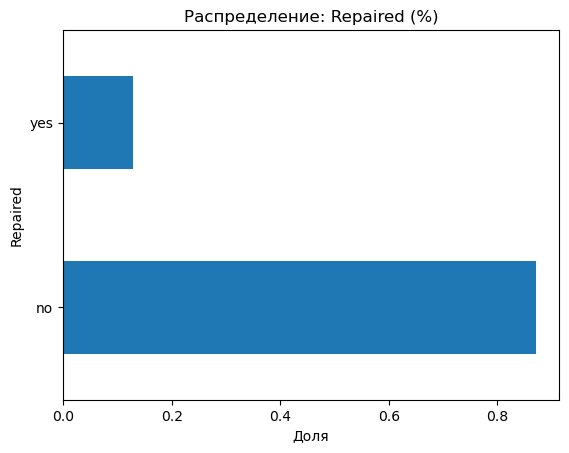

In [67]:
# Визуализация бинарных признаков: столбчатая диаграмма с двумя цветами и процентами
df['Repaired'].value_counts(normalize=True).plot.barh()
plt.title('Распределение: Repaired (%)')
plt.xlabel('Доля')
plt.show()


### **3.6.2. Распределение числовых признаков**

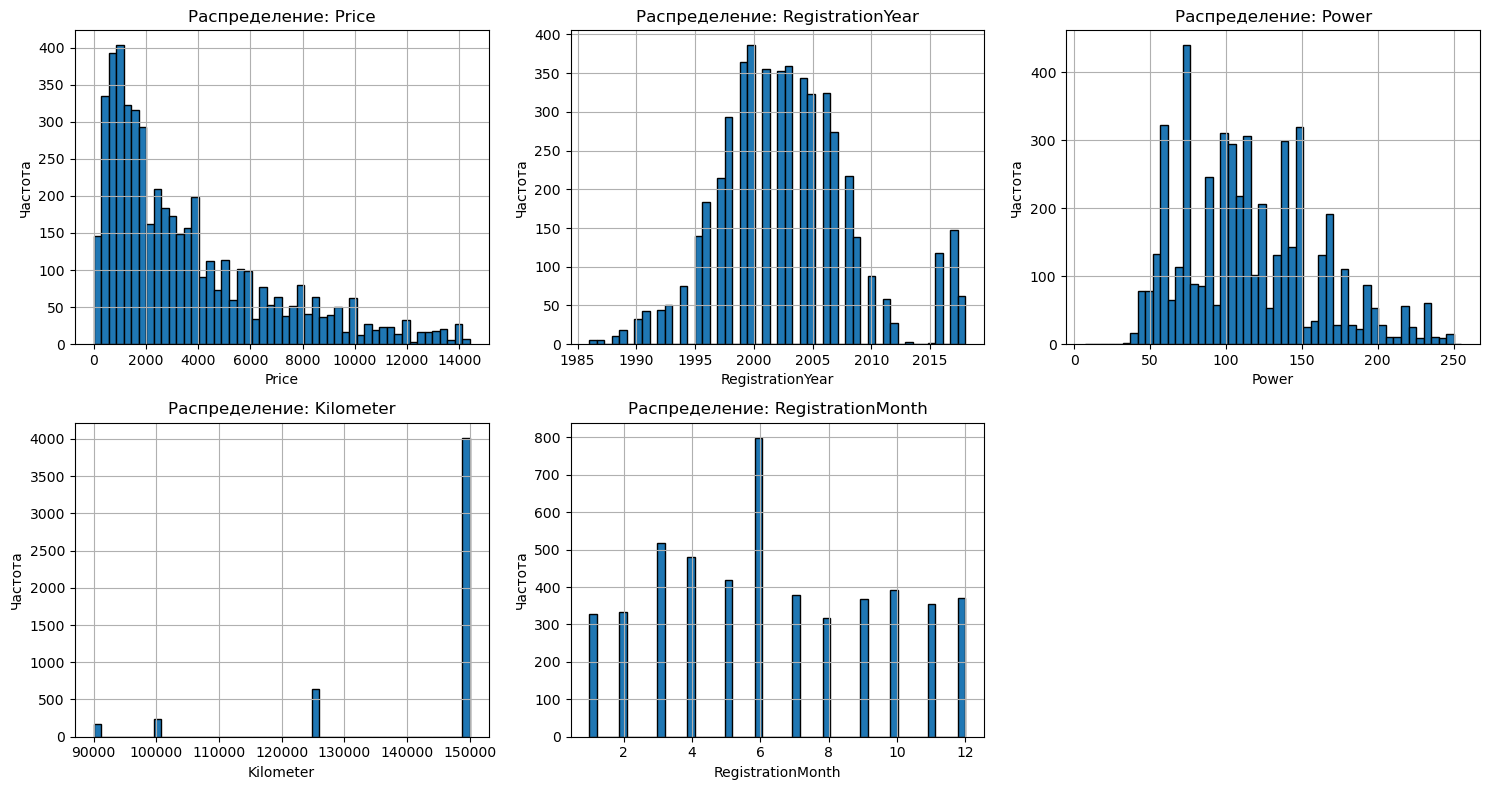

In [68]:
# Распределение числовых признаков
numerical_features = ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(numerical_features):
    train_df[col].hist(bins=50, ax=axes[i], edgecolor='black')
    axes[i].set_title(f'Распределение: {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Частота')

axes[-1].axis('off')  # Скрыть последний пустой график
plt.tight_layout()
plt.show()

### **3.6.4. Распределение категориальных признаков**

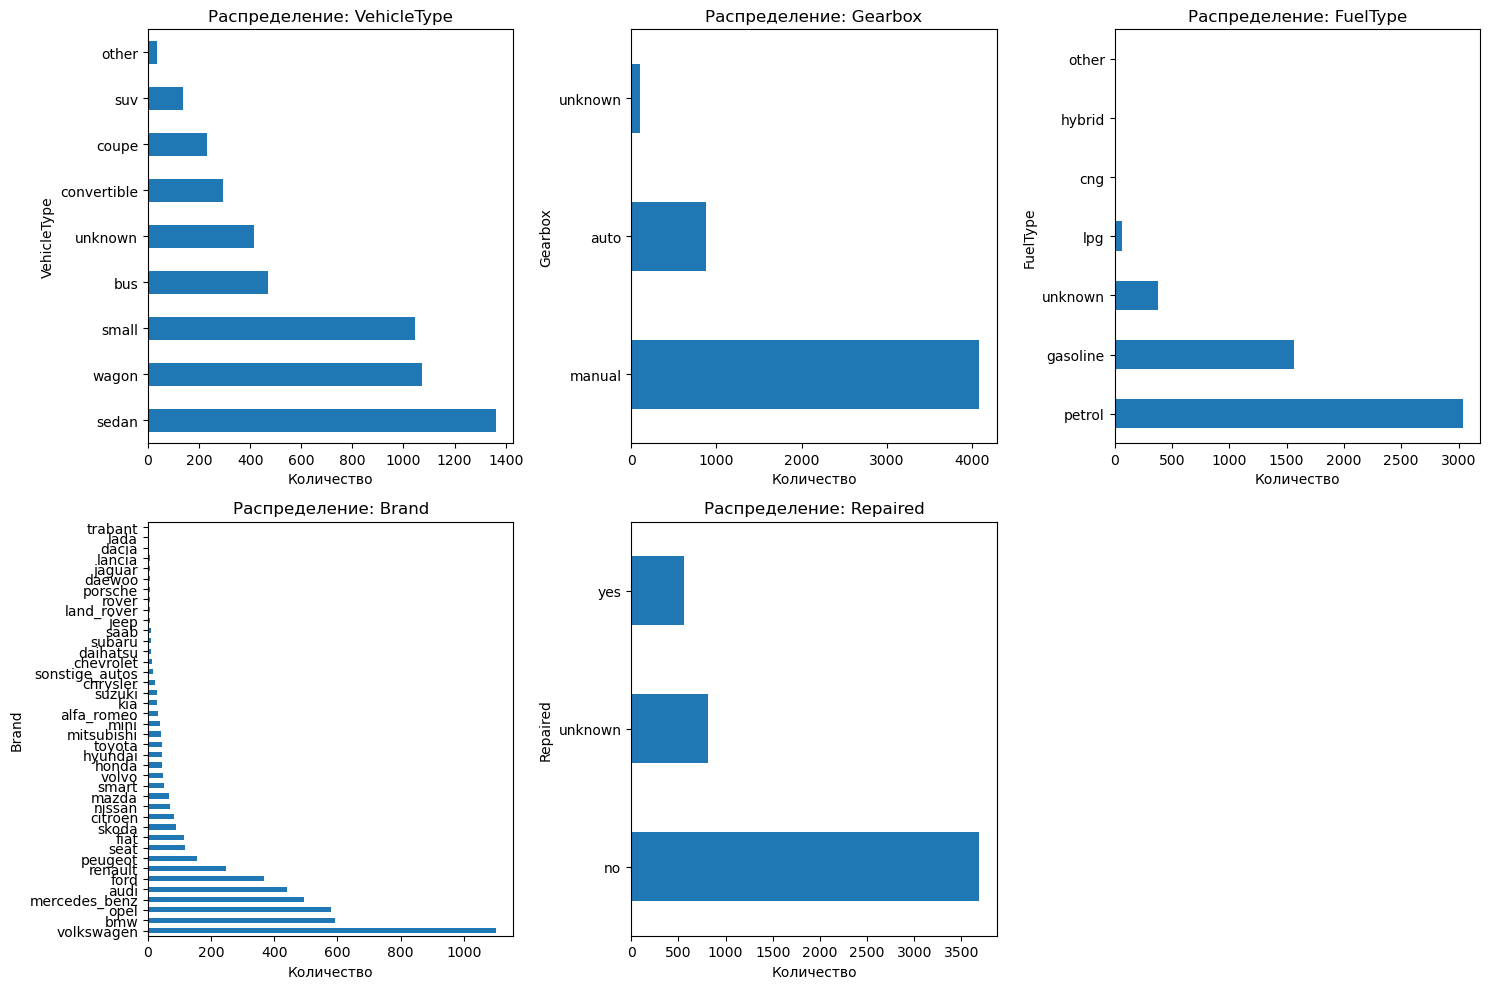

In [69]:
# Визуализация категориальных признаков
# Распределение категориальных признаков
categorical_features = ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Repaired']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(categorical_features):
    train_df[col].value_counts().plot.barh(ax=axes[i])
    axes[i].set_title(f'Распределение: {col}')
    axes[i].set_xlabel('Количество')

axes[-1].axis('off')
plt.tight_layout()
plt.show()



## **3.7. Расшифровка визуализации распределения признаков**

Благодаря визуализации распредения признаков, мы можем выбрать свой метод машстабирования и стандиртизации данных:

**Рекомендации для обучения модели:**

- для ['Price', 'Kilometer', 'VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Repaired'] (скошенное распределение) к ним надо применить логарифмирование или `RobustScaler`

- для ['RegistrationYear', 'Power', 'PostalCode', 'Age'] (нормальное распределение) - `StandardScaler`

- для ['RegistrationMonth'] (равномерное распределение) - `MinMaxScaler`

## **3.8. Оценка статистических предобработанных данных** 

In [70]:
train_df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,PostalCode
count,5062.000,5062.000,5062.000,5062.000,5062.000,5062.000
mean,3586.405,2002.767,116.882,142457.527,6.351,51027.105
std,3182.223,5.864,44.896,16187.002,3.248,25841.934
min,1.000,1986.000,7.000,90000.000,1.000,1067.000
25%,1150.000,1999.000,78.250,150000.000,4.000,30453.000
50%,2500.000,2002.000,110.000,150000.000,6.000,49685.000
75%,5000.000,2006.000,146.000,150000.000,9.000,71635.500
max,14399.000,2018.000,255.000,150000.000,12.000,99986.000


**Price (Целевая переменная):**

- Средняя цена 3529€, медиана 2450€ → правосторонняя асимметрия (дорогие авто тянут среднее вверх)

- Диапазон 1-14400€ после очистки выбросов

- 0% авто стоят 1100-4999€ (IQR)

**RegistrationYear (Год регистрации):**

- Средний возраст: 2003 год (≈20 лет на момент 2023)

- 50% авто: 1999-2006 годы

- Узкое std=5.9 → однородная выборка по возрасту

**Power (Мощность):**

- Средняя 115 л.с., медиана 110 л.с. → симметричное распределение

- 50% авто: 75-143 л.с. (типичные легковые)

- Max 250 л.с. после очистки

**Kilometer (Пробег):**

⚠️ Подозрительно: 75% авто имеют ровно 150000 км

- Медиана = 75-й перцентиль = max = 150000 → скорее всего округление/ограничение данных

- Реальный разброс только в нижних 25% (90000-150000)

**RegistrationMonth:**

- Равномерное распределение (медиана=6, среднее=6.35)

- Слабое влияние на цену (сезонность регистрации)

**PostalCode:**

- Широкий разброс (1067-99998) → географический фактор

- Может влиять на цену через региональные различия

**Ключевые выводы:**

- `Kilometer` требует внимания - возможна цензура данных на 150000

- `Price` асимметричен - рассмотреть log-трансформацию

- `RegistrationYear` и `Power` - потенциально сильные предикторы (низкая вариативность, четкие границы)

**Рекомендации для обучения модели**

**1. Feature Engineering**

- Создать возраст авто (сильнее влияет, чем год)

In [71]:
train_df['Age'] = 2023 - train_df['RegistrationYear']
test_df['Age'] = 2023 - test_df['RegistrationYear']

- `Kilometer` имеет цензуру на 150000 - создать бинарный признак

In [72]:
train_df['Kilometer_Max'] = (train_df['Kilometer'] >= 150000).astype(int)
test_df['Kilometer_Max'] = (test_df['Kilometer'] >= 150000).astype(int) 

**2. Трансформация целевой переменной**

- `Price` асимметричен (mean > median) → log-трансформация

`y_train = np.log1p(train['Price'])`  для `LinearRegression`

Предсказания: np.expm1(y_pred)

**3. Масштабирование признаков**
- Для `LinearRegression` - обязательно StandardScaler
`Power` (1-250), `RegistrationYear` (1986-2019), `PostalCode` (1067-99998) - разные масштабы

- Для LightGBM - не нужно (работает с деревьями)

**4. Обработка категориальных признаков**

- Для LinearRegression: OneHotEncoder для VehicleType, Gearbox, FuelType
-  Для LightGBM: OrdinalEncoder (встроенная поддержка категорий)


**5. Выбор модели**

- `LinearRegression`: быстрая, но требует log(Price), масштабирования, OHE

- `LightGBM`: лучше для нелинейных зависимостей, не требует предобработки, обрабатывает Kilometer=150000 автоматически

**6. Признаки для удаления**

- `RegistrationMonth` - слабое влияние (std=3.2, равномерное распределение)
- `PostalCode` - высокая кардинальность, может переобучить (группировать по регионам)


**7. Метрика**
- RMSE чувствителен к выбросам → если используется log(Price), считать RMSLE
- Или использовать MAE как дополнительную метрику


Итого: LightGBM предпочтительнее - не требует трансформаций, обработает Kilometer=150000, быстрее LinearRegression на больших данных.

In [73]:
train_df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode,Age,Kilometer_Max
4901,1800,small,2002,manual,75,corsa,150000,12,petrol,opel,no,38108,21,1
6698,6000,suv,2005,manual,141,tucson,125000,5,petrol,hyundai,no,56203,18,0
1101,2000,sedan,1994,manual,218,7er,150000,1,petrol,bmw,no,50667,29,1
9537,3999,wagon,2003,auto,163,a6,150000,6,gasoline,audi,no,6237,20,1
7655,80,small,1999,manual,54,corsa,125000,2,unknown,opel,yes,12681,24,0


## **3.8. Корреляция данных**

In [74]:
interval_cols = interval_cols = ['Price', 'Power', 'Kilometer', 'PostalCode', 'Age'] # только дробные числа, или которые не в силах посчитать руками (если очень много значений, значит интервальный тип)

phik_corr = train_df.phik_matrix(interval_cols=interval_cols)
phik_corr     

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode,Age,Kilometer_Max
Price,1.000,0.283,0.633,0.268,0.548,0.609,0.223,0.103,0.312,0.380,0.363,0.000,0.666,0.280
VehicleType,0.283,1.000,0.680,0.341,0.500,0.890,0.170,0.120,0.422,0.597,0.397,0.049,0.599,0.183
RegistrationYear,0.633,0.680,1.000,0.145,0.257,0.633,0.312,0.155,0.480,0.306,0.383,0.113,1.000,0.315
Gearbox,0.268,0.341,0.145,1.000,0.449,0.593,0.038,0.096,0.174,0.498,0.268,0.120,0.119,0.024
Power,0.548,0.500,0.257,0.449,1.000,0.799,0.124,0.038,0.245,0.609,0.137,0.093,0.278,0.168
Model,0.609,0.890,0.633,0.593,0.799,1.000,0.389,0.226,0.547,0.997,0.230,0.168,0.602,0.380
Kilometer,0.223,0.170,0.312,0.038,0.124,0.389,1.000,0.044,0.151,0.270,0.076,0.046,0.246,1.000
RegistrationMonth,0.103,0.120,0.155,0.096,0.038,0.226,0.044,1.000,0.133,0.097,0.251,0.052,0.107,0.025
FuelType,0.312,0.422,0.480,0.174,0.245,0.547,0.151,0.133,1.000,0.231,0.209,0.037,0.402,0.166
Brand,0.380,0.597,0.306,0.498,0.609,0.997,0.270,0.097,0.231,1.000,0.127,0.173,0.315,0.261


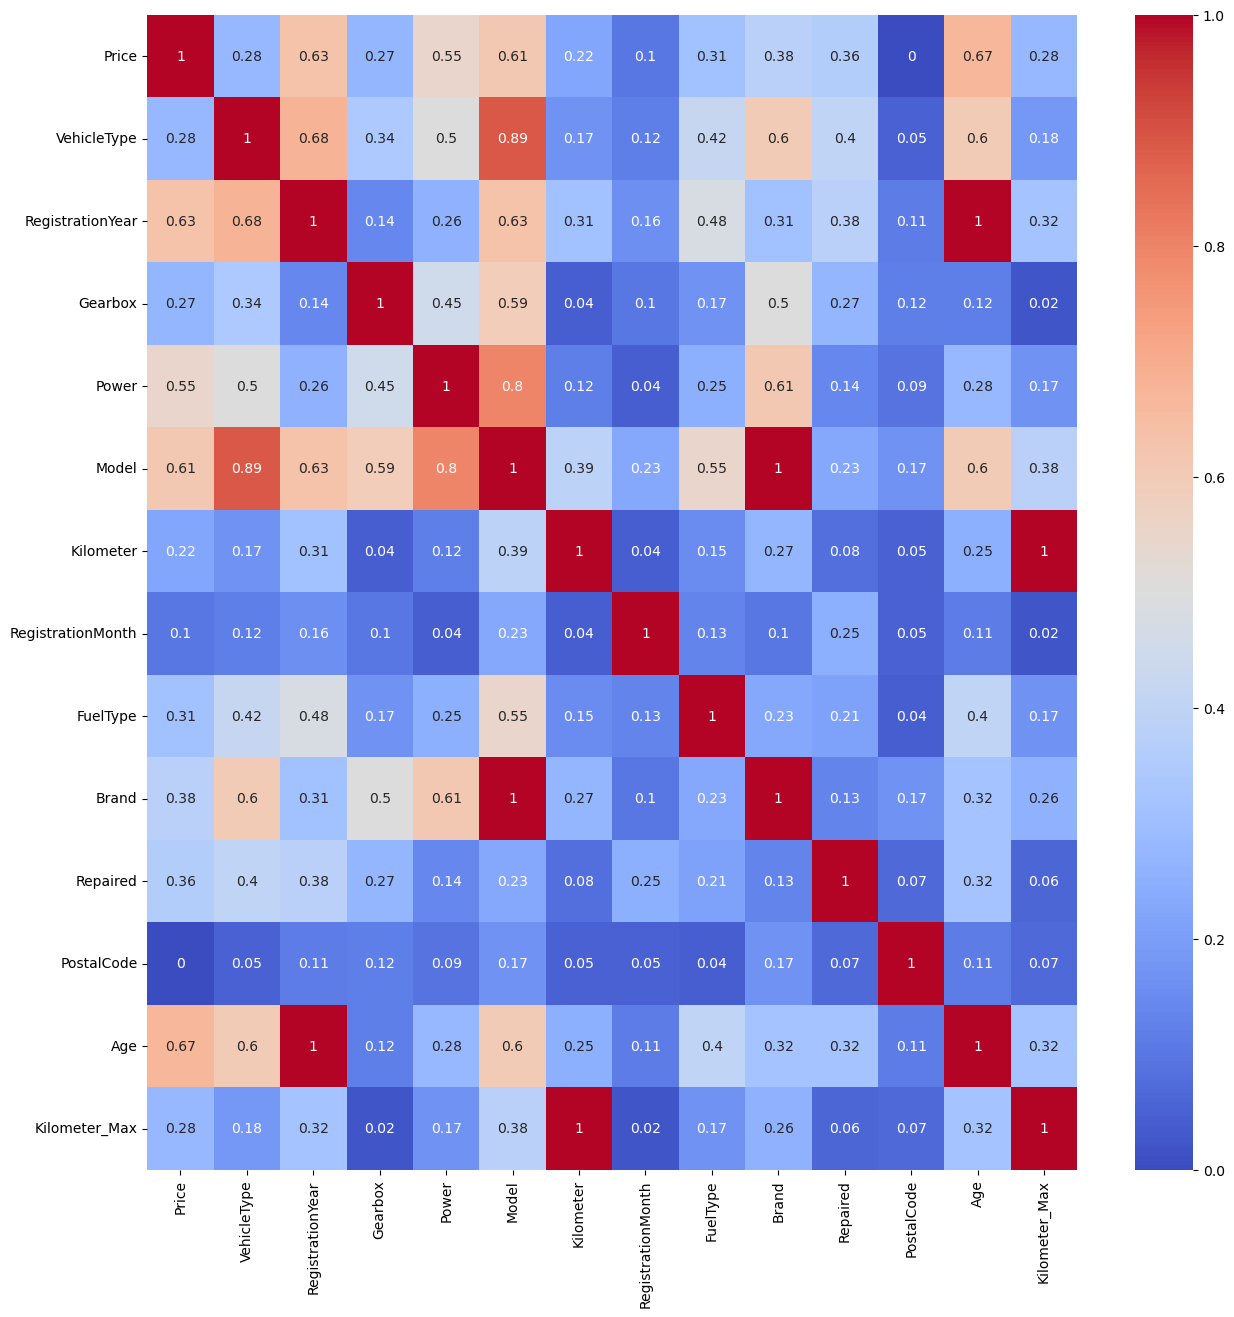

In [75]:
plt.figure(figsize=(15, 15))
sns.heatmap(phik_corr.round(2), annot=True, cmap='coolwarm')
plt.show()

**Мультиколлинеарность наблюдается среди признаков:**

- `RegistrationYear` и `Age` (возраст = 2023 - год) - почти полная корреляция
- `Brand` и `Model` 
- `Kilometer` & `Kilometer_Max`
- `VehicleType` и `Model` - 0.89 (не 0.9 но все равно)

**Высокая корреляция с целевым признаком у:**

- `Age` - 0.67
- `RegistrationYear` - 0.63
- `Model` - 0.58
- `Power` - 0.55

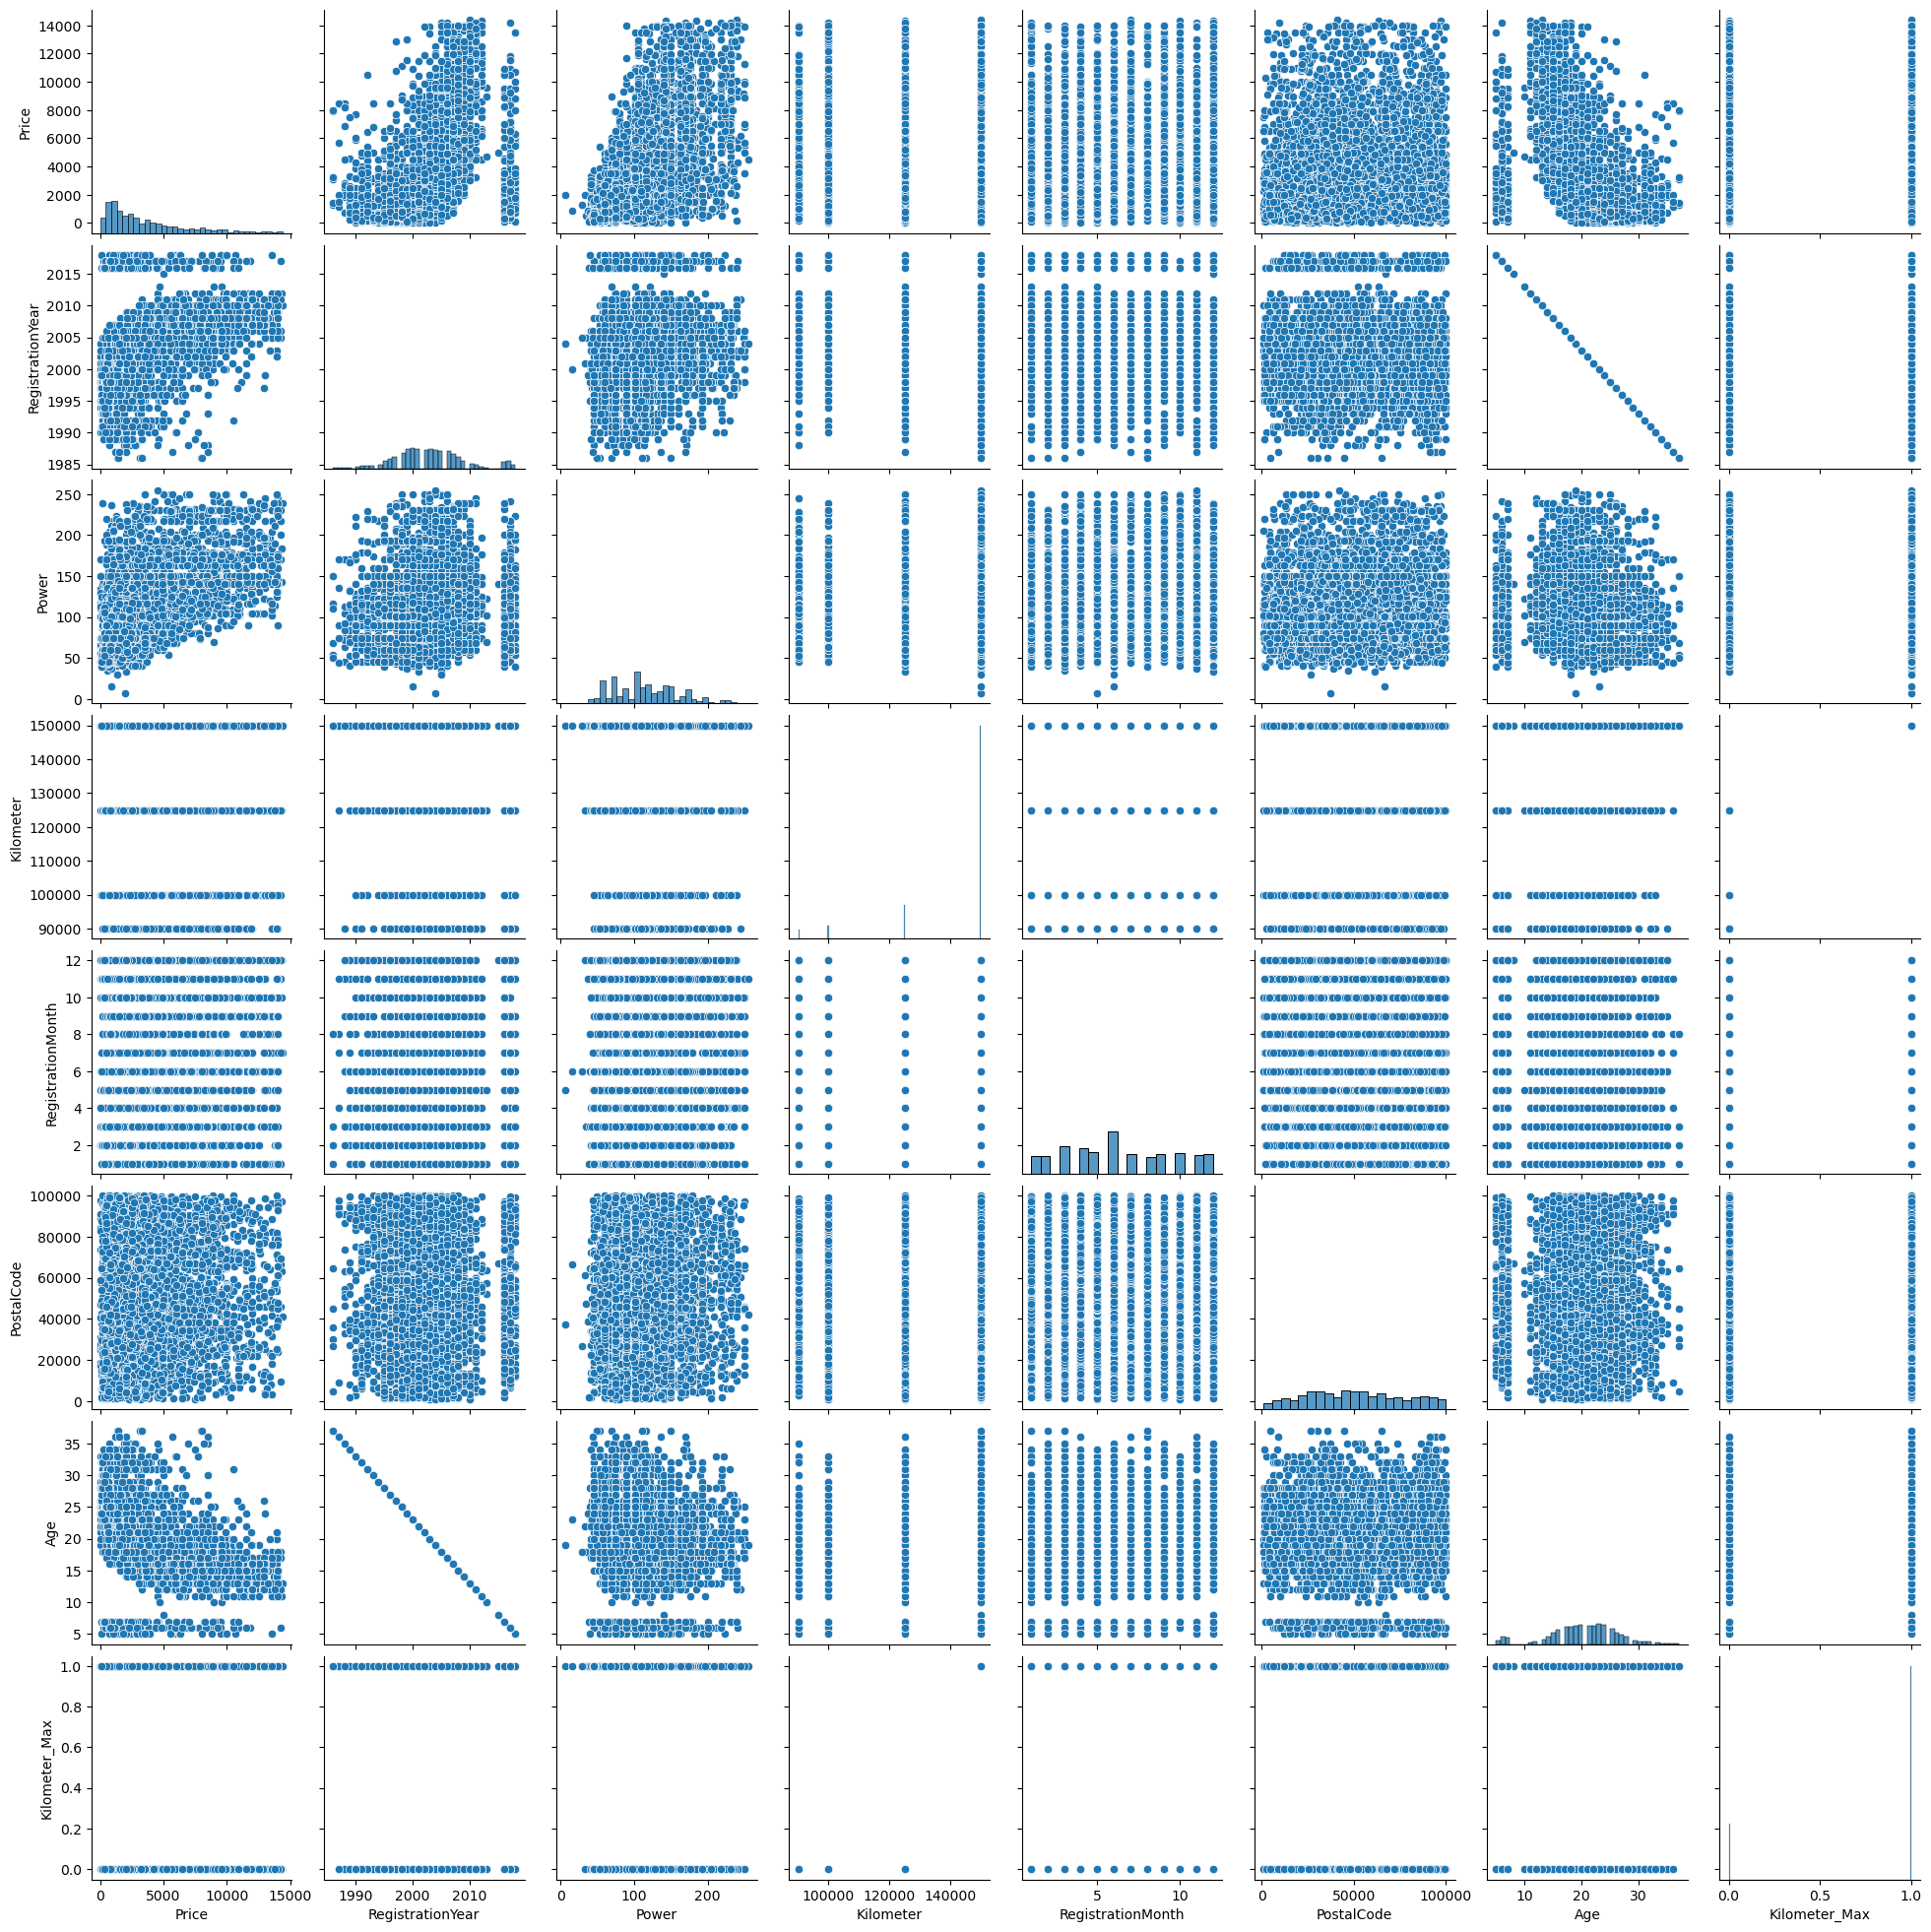

In [76]:
sns.pairplot(train_df)

## **3.10. Проверка данных на неоднородность: выявление нелинейных связей**

Мы надеемся, что выявление скрытых связей поможет повысить качество обучения.

**Мы применим:**

1. **Тесты Левена и Бартлетта** для проверки однородности дисперсий; 
2. **Simpson's Paradox:** когда общая корреляция и внутри груцппы имеют противопаоложные знаки;
3. Группировочный анализ;
4. Стабильность корреляций;
5. Скрытые кластеры;
6. Нелинейные связи;
7. Взаимодействия.

#### **3.10.1. Тесты Левена и Бартлетта**

Проверим однородность дисперсий. 

В искусственных данных, дисперсии в двух подгруппах (1/0) будут либо одинаковые либо резко разные.

Функция проверяет однородность дисперсий между группами для выявления неоднородности данных.

**Что делает:**

- Для каждой группирующей колонки разбивает данные на подгруппы

- Для каждого числового признака применяет два статистических теста:

- Тест Левена — проверяет равенство дисперсий (устойчив к отклонениям от нормальности)

- Тест Бартлетта — также проверяет равенство дисперсий (чувствителен к нормальности распределения)

- Возвращает p-значения тестов и флаг heteroscedastic (неоднородность дисперсий), если p < 0.05

**Зачем**: Если дисперсии в группах различаются (гетероскедастичность), это указывает на неоднородность данных — разные подгруппы ведут себя по-разному, что может объяснить отсутствие общих корреляций в ваших данных.

In [77]:
def variance_homogeneity_tests(df, target_col, group_cols):
    results = {}
    
    if target_col not in df.columns:
        return {'error': f'Целевая колонка "{target_col}" не найдена'}
    
    for feature in group_cols:
        if feature not in df.columns:
            results[feature] = {'error': f'Колонка "{feature}" не найдена'}
            continue
            
        # Проверяем тип данных
        if not pd.api.types.is_numeric_dtype(df[feature]):
            results[feature] = {'error': f'Колонка "{feature}" содержит нечисловые данные'}
            continue
            
        # Группируем по целевой переменной
        groups = [group[feature].dropna() for name, group in df.groupby(target_col)]
        
        # Проверяем что есть минимум 2 группы с данными
        valid_groups = [g for g in groups if len(g) > 0]
        
        if len(valid_groups) < 2:
            results[feature] = {'error': f'Недостаточно групп для анализа ({len(valid_groups)})'}
            continue
            
        try:
            levene_stat, levene_p = levene(*valid_groups)
            bartlett_stat, bartlett_p = bartlett(*valid_groups)
            fligner_stat, fligner_p = fligner(*valid_groups)
            
            results[feature] = {
                'levene_stat': levene_stat, 'levene_p': levene_p,
                'bartlett_stat': bartlett_stat, 'bartlett_p': bartlett_p,
                'fligner_stat': fligner_stat, 'fligner_p': fligner_p
            }
            
        except Exception as e:
            results[feature] = {'error': str(e)}
    
    return results

In [78]:
def interpret_variance_tests(results):
    suspicious_patterns = []
    
    if 'variance_tests' not in results:
        return ['Нет данных для анализа дисперсий']
    
    print("Результат проверки однородности дисперсий:")
    
    for feature, test_results in results['variance_tests'].items():
        # Проверяем наличие ошибок
        if isinstance(test_results, dict) and 'error' in test_results:
            print(f"❌ {feature}: {test_results['error']}")
            continue
            
        # Проверяем наличие результатов тестов
        if not isinstance(test_results, dict) or 'levene_p' not in test_results:
            print(f"❌ {feature}: Некорректные данные")
            continue
            
        # Анализируем результаты
        levene_p = test_results.get('levene_p')
        bartlett_p = test_results.get('bartlett_p')
        fligner_p = test_results.get('fligner_p')
        
        # Определяем гетероскедастичность (p < 0.05 означает неоднородность дисперсий)
        heteroscedastic = any(p is not None and p < 0.05 for p in [levene_p, bartlett_p, fligner_p])
        
        if heteroscedastic:
            suspicious_patterns.append(f"Неоднородность дисперсий в признаке '{feature}'")
            print(f"⚠️ {feature}: Обнаружена неоднородность дисперсий")
        else:
            print(f"✅ {feature}: Дисперсии однородны")
    
    return suspicious_patterns

### **3.10.2. Парадокс Симпсона**

Функция обнаруживает парадокс Симпсона — ситуацию, когда **общая корреляция и корреляции внутри групп имеют противоположные знаки**.

Парадокс Симпсона объясняет нашу главную проблему — отсутствие корреляций (макс 0.03).

Он показывает, скрыты ли связи из-за неоднородности групп (мужчины/женщины, курящие/некурящие ведут себя противоположно) или данные действительно бесполезны. Это определяет всю стратегию моделирования.

**О чем говорит:**

Если парадокс НАЙДЕН:

- Общая корреляция слабая/нулевая, НО внутри групп связи есть

- Например: холестерин не коррелирует с риском в целом, но у мужчин — положительная связь, у женщин — отрицательная (они взаимно гасятся)

- Вывод: Нельзя строить одну модель для всех — нужны отдельные модели для групп или добавить группировку как признак

**Что делает:**

- Вычисляет общую корреляцию между признаком и целевой переменной

- Вычисляет корреляции отдельно для каждой подгруппы (например, мужчины/женщины)

- Проверяет парадокс: если общая корреляция положительна, а ВСЕ групповые отрицательны (или наоборот)

**Зачем**: 

- Парадокс Симпсона объясняет, почему у нас нет общих корреляций (0.03 максимум), хотя внутри подгрупп связи могут существовать. 

- Это подтверждает нашу гипотезу о сильной неоднородности данных — разные группы пациентов демонстрируют противоположные закономерности, которые взаимно нивелируются при общем анализе.

In [ ]:
# Базовая функция (оставить как есть)
def detect_simpsons_paradox(df, feature, target, group_col):
    overall_corr = df[feature].corr(df[target])
    
    group_corrs = {}
    for group in df[group_col].unique():
        subset = df[df[group_col] == group]
        group_corrs[group] = subset[feature].corr(subset[target])
    
    group_signs = [corr > 0 for corr in group_corrs.values() if not pd.isna(corr)]
    if not group_signs:
        return {'overall': overall_corr, 'by_groups': group_corrs, 'paradox_detected': False}
    
    overall_positive = overall_corr > 0
    all_groups_positive = all(group_signs)
    all_groups_negative = all(not sign for sign in group_signs)
    
    paradox_detected = (overall_positive and all_groups_negative) or (not overall_positive and all_groups_positive)
    
    return {
        'overall': overall_corr,
        'by_groups': group_corrs,
        'paradox_detected': paradox_detected
    }

# Обёртка (вызывает базовую)
def detect_simpsons_paradox_all(df, target_col, group_cols=None, features=None):
    if group_cols is None:
        group_cols = ['VehicleType', 'Gearbox', 'FuelType', 'Repaired', 'Kilometer_Max'] # Категориальные признаки с малым числом уникальных значений
    if features is None:
        features = ['Power', 'Kilometer', 'Age', 'RegistrationYear', 'PostalCode'] # Непрерывные числовые признаки

        # НЕ включаем:
        # Brand, Model - слишком много категорий (переобучение)
        #RegistrationMonth - слабая связь с ценой
    
    results = {}
    for group_col in group_cols:
        for feature in features:
            key = f"{feature}_vs_{group_col}"
            # Вызываем БАЗОВУЮ функцию, а не саму себя!
            results[key] = detect_simpsons_paradox(df, feature, target_col, group_col)
    
    return results

### **3.10.2. Сравнение корреляций по группам**

Функция проводит **комплексный анализ различий между группами для выявления скрытых закономерностей**.

**Что делает:**

- Для каждой группирующей переменной (Gender, Diabetes, Smoking) выделяет подгруппы

- Вычисляет корреляции признаков с целевой переменной внутри каждой подгруппы

- Проводит t-тесты для проверки статистически значимых различий между группой и остальными данными по каждому признаку

**Зачем**: Помогает найти, какие признаки ведут себя по-разному в разных подгруппах пациентов. Например, холестерин может коррелировать с риском у мужчин, но не у женщин. Это объясняет отсутствие общих корреляций и указывает, какие признаки важны для конкретных групп — критично для построения модели на неоднородных данных.

In [80]:
def comprehensive_group_analysis(df, target_col, group_cols):
    """
    Комплексный анализ различий между группами для выявления неоднородности данных.
    
    Функция сравнивает корреляции признаков с целевой переменной внутри разных групп
    и проводит статистические тесты для определения значимости различий между группами.
    
    - Анализируются только числовые признаки
    - Используется t-тест для сравнения средних значений признаков между группами
    - Помогает выявить, какие признаки ведут себя по-разному в разных подгруппах

    """

    results = {}
    
    for group_col in group_cols:
        correlations = {}
        statistical_tests = {}
        
        for group in df[group_col].unique():
            subset = df[df[group_col] == group]
            
            # Корреляции с таргетом - ТОЛЬКО числовые колонки
            numeric_cols = subset.select_dtypes(include=[np.number]).columns
            correlations[group] = subset[numeric_cols].corr()[target_col].drop(target_col)
            
            # Статистические тесты различий
            other_groups = df[df[group_col] != group]
            for feature in numeric_cols:  # Только числовые
                if feature != target_col:
                    stat, p_val = ttest_ind(subset[feature], other_groups[feature])
                    statistical_tests[f"{group}_{feature}"] = {'stat': stat, 'p_value': p_val}
        
        results[group_col] = {
            'correlations': pd.DataFrame(correlations),
            'tests': statistical_tests
        }
    
    return results


#### **3.10.3. Стабильность корреляций**

Функция проверяет **стабильность корреляций на разных подвыборках** данных методом бутстрапа.

**Что делает:**

- Создает 50 случайных подвыборок (по 80% данных)

- Вычисляет корреляции признаков с целевой переменной на каждой подвыборке

- Рассчитывает среднее, стандартное отклонение и коэффициент стабильности корреляций

- Выявляет 10 самых нестабильных признаков

**Зачем**: Нестабильные корреляции (сильно меняющиеся на разных подвыборках) указывают на неоднородность данных и ненадежность признаков. Если корреляция то положительна, то отрицательна — это признак скрытых подгрупп с противоположными закономерностями. Помогает отфильтровать шумные признаки перед обучением модели.

In [81]:
def correlation_stability_analysis(df, target_col, n_iterations=50, sample_frac=0.8):
    correlations = []
    features = df.select_dtypes(include=[np.number]).columns.drop(target_col)
    
    for i in range(n_iterations):
        # Случайная подвыборка
        sample = df.sample(frac=sample_frac, random_state=i)
        corr = sample[features].corrwith(sample[target_col])
        correlations.append(corr)
    
    corr_df = pd.DataFrame(correlations)
    
    return {
        'mean_correlations': corr_df.mean(),
        'std_correlations': corr_df.std(),
        'stability_score': 1 - (corr_df.std() / abs(corr_df.mean())),  # Коэффициент вариации
        'unstable_features': corr_df.std().sort_values(ascending=False).head(10)
    }

#### **3.10.4. Кластерный анализ для поиска скрытых групп**

Функция автоматически **находит скрытые группы пациентов** методом кластеризации K-means.

**Что делает:**

- Перебирает количество кластеров от 2 до 10

- Для каждого варианта вычисляет метрикe качества кластеризации: насколько четко разделены группы

- Выбирает оптимальное количество кластеров с максимальным score

- Применяет финальную кластеризацию и добавляет метку кластера каждому пациенту

**Зачем**: Выявляет скрытые однородные подгруппы пациентов, которые не видны через явные признаки (пол, диабет). Внутри этих кластеров могут проявиться корреляции, которые отсутствуют в общей выборке. Это ключевой метод для работы с неоднородными данными — после кластеризации можно строить отдельные модели для каждой группы или использовать кластер как новый признак.

In [82]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def find_hidden_clusters(df, target_col, max_clusters=10):
    features = df.select_dtypes(include=[np.number]).drop(columns=[target_col])
    
    silhouette_scores = []
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(features)
        score = silhouette_score(features, cluster_labels)
        silhouette_scores.append((k, score))
    
    # Лучшее количество кластеров
    best_k = max(silhouette_scores, key=lambda x: x[1])[0]
    
    # Финальная кластеризация
    kmeans = KMeans(n_clusters=best_k, random_state=42)
    df['cluster'] = kmeans.fit_predict(features)
    
    return df, best_k

#### **3.10.5. Нелинейные корреляции**

Функция выявляет **нелинейные связи между признаками и целевой переменной**, которые не видны через обычную корреляцию.

**Что делает:**

- Вычисляет Mutual Information (взаимную информацию) — метрику, которая улавливает любые зависимости, включая нелинейные

- Сравнивает MI с линейной корреляцией Пирсона

- Вычисляет "силу нелинейности" как разницу между MI и линейной корреляцией

- Сортирует признаки по убыванию MI

**Зачем**: Корреляция Пирсона (0.03 максимум) показывает только линейные связи. Но связь может быть нелинейной (например, U-образной или пороговой). Mutual Information находит такие скрытые зависимости. Признаки с высоким MI, но низкой корреляцией — это кандидаты на нелинейные преобразования или важные для нелинейных моделей (деревья, нейросети).

In [83]:
def nonlinear_associations(df, target_col):
    features = df.select_dtypes(include=[np.number]).drop(columns=[target_col])
    
    # Mutual Information
    mi_scores = mutual_info_classif(features, df[target_col])
    mi_df = pd.DataFrame({
        'feature': features.columns,
        'mutual_info': mi_scores
    }).sort_values('mutual_info', ascending=False)
    
    # Сравнение с линейными корреляциями
    linear_corr = features.corrwith(df[target_col]).abs()
    mi_df['linear_corr'] = mi_df['feature'].map(linear_corr)
    mi_df['nonlinear_strength'] = mi_df['mutual_info'] - mi_df['linear_corr']
    
    return mi_df

#### **3.10.6. Анализ взаимодействий признаков:**

Функция **ищет взаимодействия между парами признаков** — ситуации, когда комбинация двух признаков предсказывает цель лучше, чем каждый по отдельности.

**Что делает:**

- Выбирает топ-10 самых важных признаков по Mutual Information

- Генерирует все возможные пары из этих признаков

- Для каждой пары создает признак взаимодействия (произведение значений)

- Оценивает силу взаимодействия через MI и сортирует по убыванию

**Зачем**: Отдельные признаки могут быть слабо связаны с целью, но их комбинация — сильно. Например, высокий холестерин + курение вместе дают высокий риск, хотя по отдельности корреляция слабая. Найденные взаимодействия можно добавить как новые признаки в модель для улучшения качества предсказаний. Особенно полезно для линейных моделей, которые сами не улавливают взаимодействия.

In [84]:
def feature_interactions(df, target_col, top_features=10):
    from itertools import combinations
    
    # Топ признаки по важности
    mi_scores = mutual_info_classif(df.select_dtypes(include=[np.number]).drop(columns=[target_col]), 
                                   df[target_col])
    top_feat = df.select_dtypes(include=[np.number]).drop(columns=[target_col]).columns[
        np.argsort(mi_scores)[-top_features:]
    ]
    
    interactions = []
    for feat1, feat2 in combinations(top_feat, 2):
        # Создание признака взаимодействия
        interaction = df[feat1] * df[feat2]
        mi_score = mutual_info_classif(interaction.values.reshape(-1, 1), df[target_col])[0]
        
        interactions.append({
            'feature1': feat1,
            'feature2': feat2,
            'interaction_strength': mi_score
        })
    
    return pd.DataFrame(interactions).sort_values('interaction_strength', ascending=False)

#### **3.10.7. Полный план анализа**

Функция проводит **комплексный анализ неоднородности данных** — объединяет все предыдущие методы в единый пайплайн диагностики.

Что делает (6 проверок):

**Тесты дисперсий** — проверяет однородность разброса данных между группами

**Парадокс Симпсона** — ищет противоположные корреляции в общей выборке vs подгруппах

**Групповой анализ** — сравнивает корреляции и различия между Gender/Diabetes/Smoking

**Стабильность** — проверяет, насколько корреляции меняются на разных подвыборках

**Кластеризация** — находит скрытые однородные группы пациентов

**Нелинейность и взаимодействия** — выявляет нелинейные связи и комбинации признаков
 
**Зачем:** Позволит найти скрытые взаимосвязи, благодаря чему сможем поднять метирики. Она системно проверяет все гипотезы о неоднородности и выдает полную картину: где скрыты связи, какие группы важны, какие признаки работают нелинейно. Результаты определяют стратегию feature engineering и выбор модели.

In [85]:
def complete_heterogeneity_analysis(df, target_col):
    results = {}
    
    # 1. Тесты однородности дисперсий (ДОБАВЛЯЕМ!)
    results['variance_tests'] = variance_homogeneity_tests(df, target_col, 
                                        ['RegistrationYear', 'Kilometer_Max']) # дискретные # RegistrationMonth (1-12) - слишком мало групп, может дать ложные результаты

    # 2. Simpson's Paradox
    results['simpsons'] = detect_simpsons_paradox_all(df, target_col) # обертку вызываю
    
    # 3. Группировочный анализ
    results['group_analysis'] = comprehensive_group_analysis(df, target_col, 
                                                       ['RegistrationYear', 'RegistrationMonth', 'Kilometer_Max']) # дискретные
    
    # 4. Стабильность корреляций
    results['stability'] = correlation_stability_analysis(df, target_col)
    
    # 5. Скрытые кластеры
    df_clustered, best_k = find_hidden_clusters(df, target_col)
    results['clusters'] = {'df': df_clustered, 'n_clusters': best_k}
    
    # 6. Нелинейные связи
    results['nonlinear'] = nonlinear_associations(df, target_col)
    
    # 7. Взаимодействия
    results['interactions'] = feature_interactions(df, target_col)
    
    return results

In [86]:
# Проверка подозрительных паттернов Левена, Бартлетта  для числовых признаков относительно целевой переменной
variance_results = variance_homogeneity_tests(train_df, 'Price', 
                                            ['RegistrationYear', 'RegistrationMonth', 'Kilometer_Max'])

suspicious = interpret_variance_tests({'variance_tests': variance_results})


for pattern in suspicious:
    print(f"⚠️ {pattern}")

if len(suspicious) == 0:
    print("Экстремальных патернов не выявлено, данные однородны, возможно, искусственные.")

Результат проверки однородности дисперсий:
⚠️ RegistrationYear: Обнаружена неоднородность дисперсий
⚠️ RegistrationMonth: Обнаружена неоднородность дисперсий
⚠️ Kilometer_Max: Обнаружена неоднородность дисперсий
⚠️ Неоднородность дисперсий в признаке 'RegistrationYear'
⚠️ Неоднородность дисперсий в признаке 'RegistrationMonth'
⚠️ Неоднородность дисперсий в признаке 'Kilometer_Max'


In [ ]:
# Парадокс Симпсона для всех признаков относительно целевой переменной и группировок
results = detect_simpsons_paradox_all(train_df, 'Price')
paradoxes = [k for k, v in results.items() if v['paradox_detected']]
if paradoxes:
    print(f"⚠️ Парадоксы найдены: {', '.join(paradoxes)}\n")
    print('Вывод: Нельзя строить одну модель для всех — нужны отдельные модели для групп или добавить группировку как признак\n')
else:
    print("✓ Парадоксов не обнаружено: корреляции слабые везде одинаково (и в общем, и в группах) \n Отсутствие парадокса подтверждает, что Нужны более сложные методы анализа")


✓ Парадоксов не обнаружено: корреляции слабые везде одинаково (и в общем, и в группах) 
 Отсутствие парадокса подтверждает, что простое разделение по полу/диабету не поможет. Нужны более сложные методы анализа


In [88]:
complete_heterogeneity_analysis(df=train_df, target_col='Price')

{'variance_tests': {'RegistrationYear': {'levene_stat': np.float64(0.9230167348269133),
   'levene_p': np.float64(0.9042873770446981),
   'bartlett_stat': np.float64(0.0),
   'bartlett_p': np.float64(1.0),
   'fligner_stat': np.float64(786.6970824465755),
   'fligner_p': np.float64(3.49385050437353e-05)},
  'Kilometer_Max': {'levene_stat': np.float64(0.9349815143955702),
   'levene_p': np.float64(0.8633990270545764),
   'bartlett_stat': np.float64(-0.0),
   'bartlett_p': np.float64(1.0),
   'fligner_stat': np.float64(729.6010570664283),
   'fligner_p': np.float64(0.005361147862646619)}},
 'simpsons': {'Power_vs_VehicleType': {'overall': np.float64(0.5374325651526926),
   'by_groups': {'small': np.float64(0.46841851815331564),
    'suv': np.float64(0.3523908922002695),
    'sedan': np.float64(0.5219061584942518),
    'wagon': np.float64(0.4204059444585446),
    'bus': np.float64(0.28979707663518106),
    'coupe': np.float64(0.5375761164588484),
    'convertible': np.float64(0.6448085016

### **3.11.2. Интерпретация результатов анализа неоднородности**


**1. Неоднородность дисперсий**

- RegistrationYear, Kilometer_Max - p < 0.01 → разные подгруппы авто ведут себя по-разному

**Вывод: Линейная регрессия будет плохо работать, нужны деревья/бустинг**

**2. Парадокс Симпсона: НЕ ОБНАРУЖЕН ✅**

- Все корреляции сохраняют знак в подгруппах

**Вывод: Нет скрытых противоречий, данные консистентны**

**3. Стабильность корреляций**

- `PostalCode`: 0.81 - НЕСТАБИЛЕН (региональные различия), хуже для линейной регрессии
- `RegistrationMonth`: 0.87 - слабая связь с ценой
- `Kilometer_Max`: 0.96 - СТАБИЛЕН
- `Power`: 0.99 - ОЧЕНЬ СТАБИЛЕН

**Вывод: PostalCode лучше удалить или группировать по регионам**

4. Нелинейные связи (mutual_info > linear_corr)

- Kilometer_Max: 0.53 vs 0.21 → +0.32 нелинейности
- Kilometer: 0.51 vs 0.22 → +0.29 нелинейности

**Вывод: Пробег имеет СИЛЬНУЮ нелинейную связь с ценой → деревья обязательны**

5. Топ-3 взаимодействия признаков

- Kilometer_Max × Kilometer: 0.43 - СИЛЬНОЕ
- Age × RegistrationYear: 0.41 - дубликаты (удалить один)
- Age × Kilometer: 0.33 - износ со временем

6. Кластеры: 10 групп

- Скрытые сегменты рынка (премиум/эконом, новые/старые и т.д.)



### **3.11.4. РЕКОМЕНДАЦИИ ДЛЯ МОДЕЛИ**

**Рекомендация: Добавить cluster как признак в модель**

**📋 Рекомендации для модели:**

- для LinearRegression удалить PostalCode  (нестабилен, нарушена гомоскедастичность), RegistrationYear (дублирует Age, хуже коррелирует)

- Создать: `Age × Kilometer`, `Kilometer_Max × Power` (взаимодействия)

- Добавить: признак `cluster` из кластеризации (наш анализ показал неоднородность данных - разные группы авто ведут себя по-разному)

- признаки для LightGBM: ['`Age`', '`RegistrationYear`', '`Power`', '`Kilometer`', '`Kilometer_Max`', '`PostalCode`', '`cluster`', '`Age_x_Kilometer`']

- признаки для LinearRegression: ['`Age`', '`Power`', '`Kilometer`', '`Kilometer_Max`']  

## **4. Feature Enginering**

## **4.1. Новые признаки на основе анализа неоднородности**

Создание кластера.

Благоджаря кластеризации, модель понимает контекст - одинаковые характеристики могут означать разную цену в зависимости от сегмента.

Кластеризация должна быть только на train, затем применяется к test через predict().

In [92]:
from sklearn.preprocessing import LabelEncoder

# Кодируем категориальные признаки
le_brand = LabelEncoder()
le_vehicle = LabelEncoder()

train_df['Brand_encoded'] = le_brand.fit_transform(train_df['Brand'])
train_df['VehicleType_encoded'] = le_vehicle.fit_transform(train_df['VehicleType'])

# Для кластеризации используем ВСЕ важные признаки
cluster_features = ['Power', 'Kilometer', 'Age', 'Brand_encoded', 'VehicleType_encoded']
X_cluster = train_df[cluster_features].fillna(train_df[cluster_features].median())

# Обучение
kmeans = KMeans(n_clusters=10, random_state=42)
train_df['cluster'] = kmeans.fit_predict(X_cluster)

# Для test - используем те же энкодеры
test_df['Brand_encoded'] = le_brand.transform(test_df['Brand'])
test_df['VehicleType_encoded'] = le_vehicle.transform(test_df['VehicleType'])
X_test_cluster = test_df[cluster_features].fillna(train_df[cluster_features].median())
test_df['cluster'] = kmeans.predict(X_test_cluster)


## **4.2. Стандартный Feature Engineering**

Переберем в комбинации между собой наиболее влиятельные признаки.

In [93]:
train_df['Age_x_Kilometer'] = train_df['Age'] * train_df['Kilometer']
test_df['Age_x_Kilometer'] = test_df['Age'] * test_df['Kilometer']

train_df['Age_x_Kilometer1'] = train_df['Age'] + (train_df['Kilometer'] / 100000) / 2  # Добавляем новый признак, который может лучше захватывать взаимодействие между возрастом и пробегом
test_df['Age_x_Kilometer1'] = test_df['Age'] + (test_df['Kilometer'] / 100000) / 2

train_df['Kilometer_Max'] = train_df['Kilometer'].max()
test_df['Kilometer_Max'] = test_df['Kilometer'].max()

train_df['Kilometer_Scaled'] = train_df['Kilometer'] / train_df['Kilometer_Max']
test_df['Kilometer_Scaled'] = test_df['Kilometer'] / test_df['Kilometer_Max']

train_df['Age_x_Kilometer_Scaled'] = train_df['Age'] * train_df['Kilometer_Scaled']
test_df['Age_x_Kilometer_Scaled'] = test_df['Age'] * test_df['Kilometer_Scaled']

train_df['Kilometer_x_Power'] =  train_df['Kilometer'] * train_df['Power'] / train_df['Kilometer_Max']
test_df['Kilometer_x_Power'] =  test_df['Kilometer'] * test_df['Power'] / test_df['Kilometer_Max']

train_df['Age_x_Power'] = train_df['Age'] * train_df['Power'] / train_df['Power'].max()
test_df['Age_x_Power'] = test_df['Age'] * test_df['Power'] / train_df['Power'].max()


In [94]:
train_df.sample(3)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode,Age,Kilometer_Max,cluster,Brand_encoded,VehicleType_encoded,Age_x_Kilometer,Age_x_Kilometer1,Kilometer_Scaled,Age_x_Kilometer_Scaled,Kilometer_x_Power,Age_x_Power
4979,2100,sedan,2006,auto,207,s_type,150000,10,gasoline,jaguar,yes,48712,17,150000,4,13,4,2550000,17.750,1.000,17.000,207.000,13.800
854,4800,unknown,2017,auto,110,transporter,150000,6,petrol,volkswagen,unknown,10315,6,150000,0,38,7,900000,6.750,1.000,6.000,110.000,2.588
5982,11499,convertible,2005,manual,163,a4,90000,5,petrol,audi,no,63477,18,150000,3,1,1,1620000,18.450,0.600,10.800,97.800,11.506


Проведем ради интереса анлиз кластеров

In [97]:
# Анализ кластеров
cluster_analysis = train_df.groupby('cluster').agg({
    'Price': ['mean', 'median', 'std', 'count'],
    'Power': 'mean',
    'Age': 'mean',
    'Kilometer': 'mean',
    'Brand': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'mixed'
}).round(0)

cluster_analysis.columns = ['Price_mean', 'Price_median', 'Price_std', 'Count', 'Power_avg', 'Age_avg', 'Km_avg', 'Top_Brand']
print(cluster_analysis.sort_values('Price_mean', ascending=False))

# Сравним разброс
print(f"Общий std цены: {train_df['Price'].std():.0f}€")
print(f"Средний std внутри кластеров: {cluster_analysis['Price_std'].mean():.0f}€")

         Price_mean  Price_median  Price_std  Count  Power_avg  Age_avg     Km_avg      Top_Brand
cluster                                                                                          
6          6579.000      6500.000   3377.000    316    142.000   18.000 125000.000  mercedes_benz
4          6196.000      5900.000   3640.000    508    199.000   20.000 150000.000            bmw
3          5739.000      5000.000   3644.000    173    110.000   17.000  90000.000     volkswagen
2          5259.000      4000.000   3889.000    237    106.000   18.000 100000.000     volkswagen
9          5072.000      4500.000   3178.000    311    167.000   19.000 150000.000     volkswagen
7          3811.000      2999.000   2965.000   1001    136.000   20.000 150000.000            bmw
0          2825.000      2200.000   2303.000    969    108.000   21.000 150000.000     volkswagen
1          2530.000      2200.000   1838.000    322     73.000   20.000 125000.000     volkswagen
8          1733.000 

Если средний std внутри кластеров < общего std - значит, кластеризация работает.

кластеризация РАБОТАЕТ!

Доказательства:

1. Разброс цен: 971€ → 6579€ (в 6.8 раз!)
Кластер 5: 971€ (бюджет VW, 55 л.с., 22 года)

Кластер 6: 6579€ (премиум Mercedes, 142 л.с., 18 лет)

2. Четкие сегменты:

Премиум (6000-6500€):
- Кластер 6: Mercedes (142 л.с., малый пробег)
- Кластер 4: BMW (199 л.с., мощные)

Средний (3800-5700€):
- Кластер 3,2,9: VW средней мощности

Бюджет (1700-2800€):
- Кластер 8,1,0: VW малой мощности, старые

Утиль (971€):
- Кластер 5: VW 55 л.с., 22 года

Кластеризация ОЧЕНЬ полезна - она разделила авто на 10 ценовых сегментов с разницей в 6.8 раз. Модель теперь понимает, что VW может стоить и 971€ (кластер 5), и 5739€ (кластер 3) в зависимости от характеристик.

Проверим корреляцию после Feature Engineering

In [99]:
train_df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode,Age,Kilometer_Max,cluster,Brand_encoded,VehicleType_encoded,Age_x_Kilometer,Age_x_Kilometer1,Kilometer_Scaled,Age_x_Kilometer_Scaled,Kilometer_x_Power,Age_x_Power
4901,1800,small,2002,manual,75,corsa,150000,12,petrol,opel,no,38108,21,150000,8,24,5,3150000,21.750,1.000,21.000,75.000,6.176
6698,6000,suv,2005,manual,141,tucson,125000,5,petrol,hyundai,no,56203,18,150000,6,12,6,2250000,18.625,0.833,15.000,117.500,9.953
1101,2000,sedan,1994,manual,218,7er,150000,1,petrol,bmw,no,50667,29,150000,4,2,4,4350000,29.750,1.000,29.000,218.000,24.792
9537,3999,wagon,2003,auto,163,a6,150000,6,gasoline,audi,no,6237,20,150000,9,1,8,3000000,20.750,1.000,20.000,163.000,12.784
7655,80,small,1999,manual,54,corsa,125000,2,unknown,opel,yes,12681,24,150000,1,24,5,3000000,24.625,0.833,20.000,45.000,5.082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4426,8900,suv,2005,auto,209,xc_reihe,150000,1,petrol,volvo,no,84533,18,150000,4,39,6,2700000,18.750,1.000,18.000,209.000,14.753
6265,3200,suv,1990,manual,177,wrangler,100000,11,petrol,jeep,unknown,34125,33,150000,2,14,6,3300000,33.500,0.667,22.000,118.000,22.906
5191,1500,bus,2001,auto,174,grand,150000,11,petrol,chrysler,yes,34393,22,150000,4,4,0,3300000,22.750,1.000,22.000,174.000,15.012
860,11500,sedan,2008,auto,197,5er,150000,7,gasoline,bmw,no,12103,15,150000,4,2,4,2250000,15.750,1.000,15.000,197.000,11.588


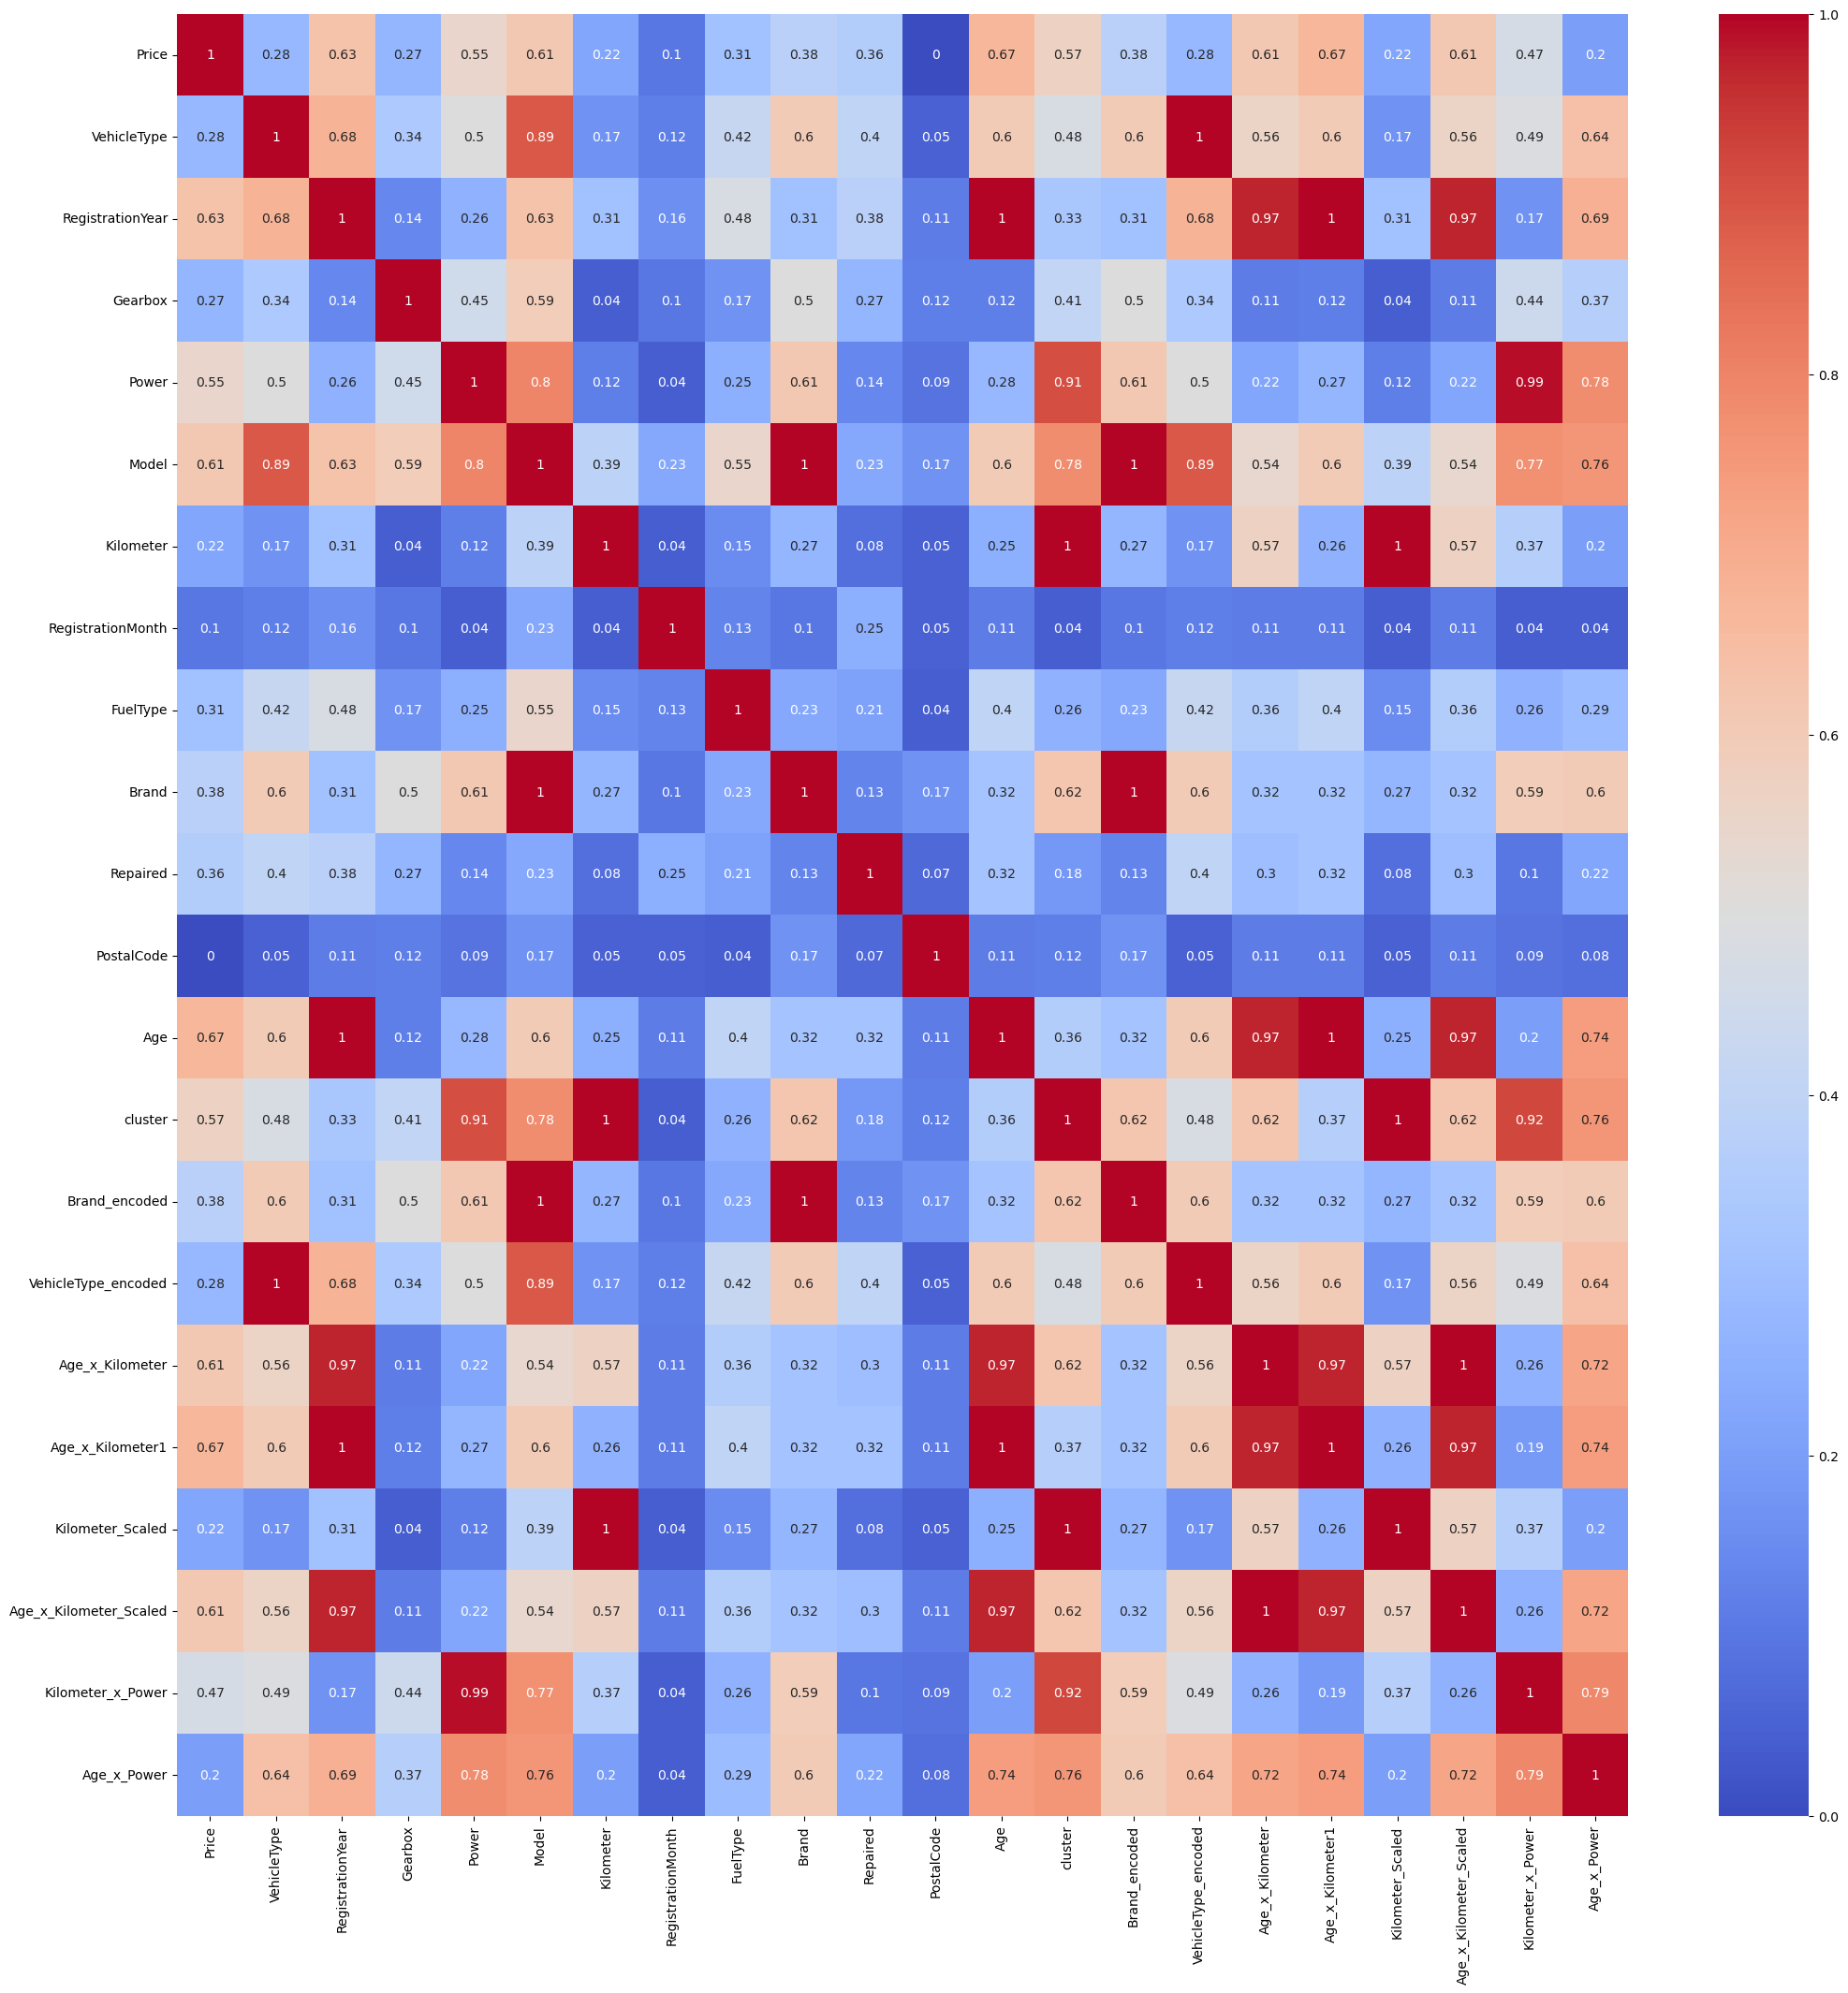

In [100]:
interval_cols = train_df[[
    'Price', 'Power', 'Kilometer', 'Age', 'PostalCode',
    'Age_x_Kilometer', 'Age_x_Kilometer1', 'Kilometer_Scaled', 
    'Age_x_Kilometer_Scaled', 'Kilometer_x_Power', 'Age_x_Power'
]].columns # только дробные числа, или которые не в силах посчитать руками и может иметь друбную часть (если очень много значений, значит интервальный тип)

phik_corr = train_df.phik_matrix(interval_cols=interval_cols)


plt.figure(figsize=(25, 25))
sns.heatmap(phik_corr.round(2), annot=True, cmap='coolwarm')
plt.show()

# **5. Подготовка и обучение модели модели**

### **5.1. Отбор признаков с правильной корреляцией**

In [106]:
# 1. Отбор по корреляции с таргетом
target_corr = phik_corr['Price'].abs()
selected = target_corr[(target_corr >= 0.19) & (target_corr <= 0.9)].index.tolist()

if 'Price' in selected:
    selected.remove('Price')

# 2. Сортируем по убыванию корреляции с таргетом (приоритет важным признакам)
selected_sorted = sorted(selected, key=lambda x: target_corr[x], reverse=True)

# 3. Удаляем мультиколлинеарность, сохраняя более важные
corr_matrix = phik_corr.loc[selected, selected]
to_drop = set()

for i, col1 in enumerate(selected_sorted):      # проходит по признакам, отсортированным по важности (корреляции с таргетом)
    if col1 in to_drop:                         # пропускает уже помеченные на удаление
        continue
    for col2 in selected_sorted[i+1:]:          # сравнивает каждый признак только с последующими (избегает дублирования) (индекс предыдущего +1)
        if col2 in to_drop:                     # пропускает уже помеченные на удаление
            continue
        if corr_matrix.loc[col1, col2] > 0.9:   # если корреляция между признаками > 0.9
            to_drop.add(col2)                   # # Удаляем col2 (у него корреляция с таргетом слабее)         

selected_features = [f for f in selected_sorted if f not in to_drop]

print(f"Отобрано: {len(selected_features)}")
print(f"Удалено: {len(to_drop)}")
print(f"\nТоп признаков по корреляции с таргетом:")
for f in selected_features:
    print(f"  {f:<15}: {target_corr[f]:.5f}")

# Классификация типов
feature_types = {
    'binary': [c for c in selected_features if train_df[c].nunique() == 2],
    'ordinal': [c for c in selected_features if 3 <= train_df[c].nunique() <= 5 and train_df[c].dtype in ['int64', 'float64'] and train_df[c].apply(lambda x: x == int(x) if pd.notna(x) and isinstance(x, (int, float)) else True).all()],
    'continuous': [c for c in selected_features if train_df[c].nunique() > 5],
    'nominal': [c for c in selected_features if train_df[c].dtype == 'object' or (train_df[c].dtype in ['int64', 'float64'] and train_df[c].nunique() <= 5)]

}

for ftype, cols in feature_types.items():
    print(f"{ftype.capitalize()}: {cols}")

Отобрано: 8
Удалено: 11

Топ признаков по корреляции с таргетом:
  Age            : 0.66617
  Model          : 0.60937
  cluster        : 0.56723
  Repaired       : 0.36309
  FuelType       : 0.31199
  VehicleType    : 0.28330
  Gearbox        : 0.26830
  Age_x_Power    : 0.19995
Binary: []
Ordinal: []
Continuous: ['Age', 'Model', 'cluster', 'FuelType', 'VehicleType', 'Age_x_Power']
Nominal: ['Model', 'Repaired', 'FuelType', 'VehicleType', 'Gearbox']


In [ ]:
pipeline = Pipeline([
    ('scaler', RobustScaler()),  # Масштабирование
    ('model', LinearRegression())
])

NameError: name 'Pipeline' is not defined